# Anaysis pipeline of _D. novamexicana_ post-mating RNAseq 

## Introduction

(Some blurb here about the project goals, sample prep, etc.)

### Load packages and generate some useful functions

The analysis below relies on several R packages and custom functions that are used for plotting and extracting gene-level annotation info. The packages can be defined and loaded like so:

In [1]:
req_packages = c("Biobase", "cluster", "cowplot", "cummeRbund", 
                 "data.table", "DESeq", "edgeR", "ggplot2", 
                 "ggrepel", "ggthemes", "ggthemr", "Glimma", 
                 "GO.db", "goseq", "gplots", "grid", "gridExtra", 
                 "heatmap3", "imager", "plotly", "qvalue", "RColorBrewer", 
                 "reshape", "Rmisc", "splitstackshape", "statmod", 
                 "VennDiagram")

lapply(req_packages, require, character.only = TRUE)

# The Cowplot package changes the default themes of ggplot2. Set the default theme like so:
theme_set(theme_gray())

Loading required package: Biobase
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, cbind, colnames, do.call,
    duplicated, eval, evalq, Filter, Find, get, grep, grepl, intersect,
    is.unsorted, lapply, lengths, Map, mapply, match, mget, order,
    paste, pmax, pmax.int, pmin, pmin.int, Position, rank, rbind,
    Reduce, rownames, sapply, setdiff, sort, table, tapply, union,
    unique, unsplit, which, which.max, which.min

Welcome to Bioconductor

    Vignettes contain introductory material; view with
    'browseVignette

[[1]]
[1] TRUE

[[2]]
[1] TRUE

[[3]]
[1] TRUE

[[4]]
[1] TRUE

[[5]]
[1] TRUE

[[6]]
[1] TRUE

[[7]]
[1] TRUE

[[8]]
[1] TRUE

[[9]]
[1] TRUE

[[10]]
[1] TRUE

[[11]]
[1] TRUE

[[12]]
[1] TRUE

[[13]]
[1] TRUE

[[14]]
[1] TRUE

[[15]]
[1] TRUE

[[16]]
[1] TRUE

[[17]]
[1] TRUE

[[18]]
[1] TRUE

[[19]]
[1] TRUE

[[20]]
[1] TRUE

[[21]]
[1] TRUE

[[22]]
[1] TRUE

[[23]]
[1] TRUE

[[24]]
[1] TRUE

[[25]]
[1] TRUE

[[26]]
[1] TRUE

[[27]]
[1] TRUE

The functions used in the analyses are in the file "Functions2.R":

In [2]:
source("Functions2.R")

These functions include: 
  * `MA_Bplot`: a function for generating MA plots and histograms of genes above 2-fold abundance
  * `plotGenePM`: for plotting mean±s.e TPM expression barplots (plotGenePM_RT plots Reproductive Tract expression only)
  * `plotHeatmap`: generic plotter for heatmaps with ggplot (requires matrix)
  * `calcSpecificity`: a function for calculating gene-wise tissue-specificity
  * `geneLookupG`: a function for extracting Trinotate annotations
  * `heatmap3`: for plotting heatmaps
  * ... and other miscellaneous RNAseq and R functions

### Load annotations, PAML data and orthology information

Some annotation files were generated from the _D. virilis_ transcriptome—in addition to miscellaneous population genetic data from the species group—that can be used here to annotate transcripts at various stages of the analysis. Load that data and process it for further use.

#### Annotations:
A Trinotate report and accompanying Gene Ontology assignments were produced in an earlier study that can be used here:

In [3]:
grpTrinotate = read.csv("Annotations/Trinotate_report_dvir1.06_subset.txt", header = T, sep = "\t", na.strings = "", stringsAsFactors=FALSE)
GO_info = read.table("Annotations/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)

Another useful annotation file is the gene features file:

In [4]:
gffRecord = read.table("Annotations/FBgn_ID_name_coordinates.txt", header = T)

From FlyBase we can obtain information on orthology to _D. melanogaster_:

In [5]:
melOrths = read.table(file = "Annotations/mel_orths.txt", header = T)
melOrthsAll = aggregate(mel_GeneSymbol~FBgn_ID, data = melOrths, toString)

Finally, we can combine the files above for convenience:

In [6]:
Annots = merge(merge(melOrthsAll, grpTrinotate, all=TRUE), gffRecord, all=TRUE)

#### PAML data

Also from the previous RNAseq study on the virilis sub-group, some PAML and Ka/Ks results can be used here:

In [7]:
tmp.FB.names = unique(subset(Annots, select=c("FBgn_ID", "FBtr_ID")))
paml.data = read.csv(file = "Annotations/PAML.branchSite.ALL.results.txt", header = T, sep = "\t")
paml.data = merge(tmp.FB.names, paml.data, all=T)
paml.data = merge(gffRecord, paml.data, all=T)
KaKs.data = read.csv(file = "Annotations/KaKs.ALL.results.txt", header = T, sep = "\t", check.names = F)
KaKs.data = merge(tmp.FB.names, KaKs.data, all=T)
KaKs.data = merge(gffRecord, KaKs.data, all=T)

We can combine gene names and descriptions with FBgn ID's in a 1:1 mapping to use in platting functions later.

In [8]:
annot.sum = unique(subset(Annots, select=c("FBgn_ID", "gene_name", "SwissProt_BlastX_Description")))
annot.sum = aggregate(SwissProt_BlastX_Description ~ FBgn_ID + gene_name, data = annot.sum, toString)

### Load expression matrices:

The raw counts from each sample obtained from `eXpress` can be loaded as a data-frame:

In [9]:
countsMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.counts.matrix", header=T, row.names=1, com='', check.names=F)

The normalized expression values—expressed in TPM units—can also be loaded as a data-frame:

In [10]:
tpmMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TMM.EXPR.matrix", header=T, row.names=1, com='', check.names=F)

Finally, a table of aggregate gene number by minimum TPM is usefull to estimate the number of expressed genes in the dataset:

In [11]:
cbmtMatrix = read.table("ExpressionData/genes_DnovPM_dvi1.06.TPM.not_cross_norm.counts_by_min_TPM", header = T)

#### Read in sample information: 

The `samples.txt` and `SamplesInfo.txt` files describe the replicate:sample mapping and additional sample information:

In [12]:
sampleData = read.table("ExpressionData/samples.txt", header=F, check.names=F, fill=T)
sampleData = sampleData[sampleData[,2] != '',]
sampleInfo = read.table("ExpressionData/SampleInfo.txt", header=T, check.names=F, fill=T)

We'll generate a data frame of mean TPM values (with standard error) for plotting individual gene barplots and heatmaps later. 

In [13]:
tmp.tpmMatrix<-tpmMatrix
colnames(tmp.tpmMatrix) <- sampleData$V1
tmp.tpmMatrix.m <- as.data.frame(melt(as.matrix(tmp.tpmMatrix)))
tmp.tpmMatrix.m <- within(tmp.tpmMatrix.m, X2<-data.frame(do.call('rbind', strsplit(as.character(X2),'_',fixed=TRUE))))
tmp.tpmMatrix.m <- data.frame(tmp.tpmMatrix.m$X1, tmp.tpmMatrix.m$X2$X1, tmp.tpmMatrix.m$X2$X2, tmp.tpmMatrix.m$value)
colnames(tmp.tpmMatrix.m) <- c("FBgn_ID", "sample", "tissue", "TPM")
tmp.tpmMatrix.m$condition <- ifelse(grepl("C", tmp.tpmMatrix.m$sample, ignore.case = F), "conspecific", ifelse(grepl("H", tmp.tpmMatrix.m$sample, ignore.case = F), "heterospecific", "virgin"))
tmp.tpmMatrix.m$time <- ifelse(grepl("3", tmp.tpmMatrix.m$sample), "3hpm", ifelse(grepl("6", tmp.tpmMatrix.m$sample), "6hpm", ifelse(grepl("12", tmp.tpmMatrix.m$sample), "12hpm","virgin")))
tmp.tpmMatrix.m.c = summarySE(tmp.tpmMatrix.m, measurevar = "TPM", groupvars = c("FBgn_ID", "sample", "tissue", "condition", "time"))
fbgn_to_geneName<-subset(gffRecord, select=c(FBgn_ID, gene_name))
TPMse <- merge(fbgn_to_geneName, tmp.tpmMatrix.m.c, all=TRUE)
tmpMat<-cast(tmp.tpmMatrix.m.c, FBgn_ID~sample+tissue, value ="TPM")
meanTPMmatrix <- tmpMat[,-1]
rownames(meanTPMmatrix) <- tmpMat[,1]
TPMse$condition = factor (TPMse$condition, levels = c("virgin", "conspecific", "heterospecific"))
TPMse$time = factor (TPMse$time, levels = c("virgin", "3hpm", "6hpm", "12hpm"))

## Quality Control:-

##### Barplot of library size

After read trimming and filtering out low quality reads, we can check the library sizes of the samples to see if we satisfy the 10-20 million read minimum:

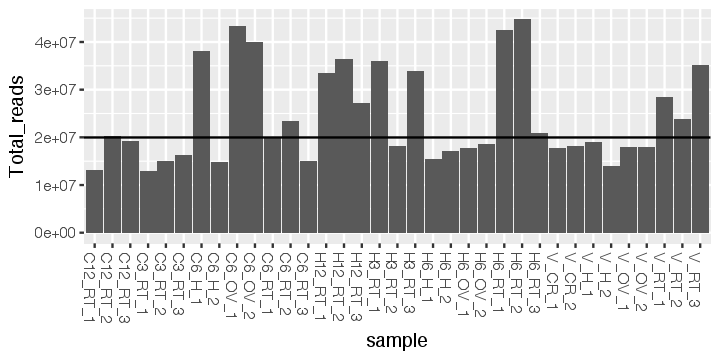

In [14]:
libSizes <- as.data.frame(colSums(countsMatrix))
libSizes <- cbind(sample = row.names(libSizes), libSizes)
row.names(libSizes)<- NULL
colnames(libSizes) = c("sample", "Total_reads")
options(repr.plot.width = 6, repr.plot.height = 3)
ggplot(libSizes, aes(sample, Total_reads)) + 
    geom_bar(stat="identity") + 
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    geom_hline(yintercept = 20000000)

Looks like all the samples have >10 million reads, so the read counts look OK.

##### Boxplot of log10(TPM) across samples

To get a sense for broad expression patterns across samples, we can generate boxplots of TPM expression across samples to see if there are large median differences between samples/replicates:

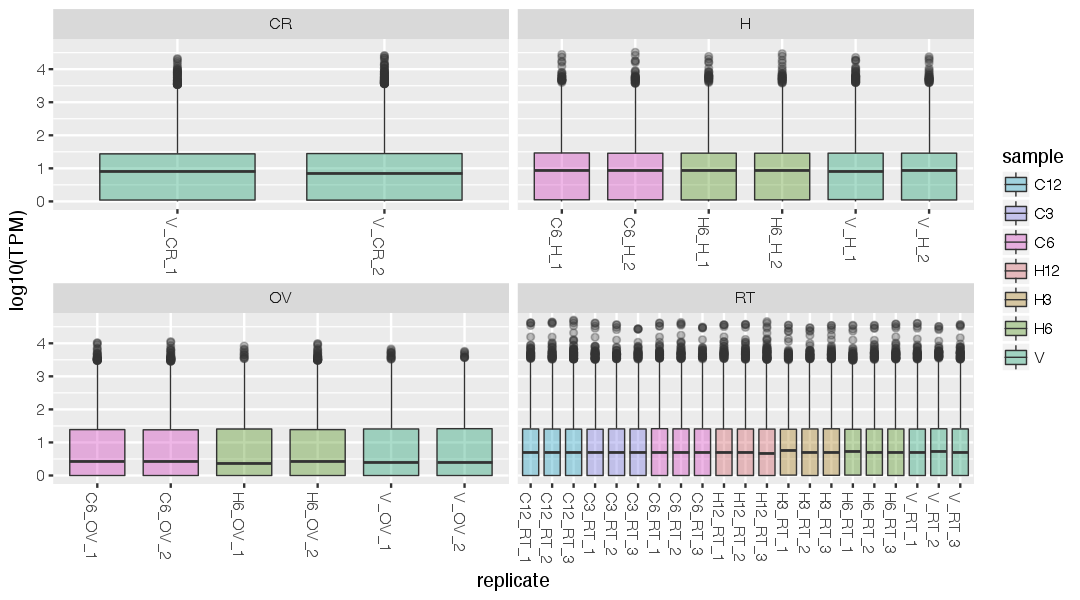

In [15]:
m.expData<-melt(as.matrix(tpmMatrix))
colnames(m.expData) <- c("gene_id", "replicate", "TPM")
m.expData.exp<- within(m.expData, replicate<-data.frame(do.call('rbind', strsplit(as.character(replicate),'_',fixed=TRUE))))
m.expData<-data.frame(m.expData, m.expData.exp$replicate$X1, m.expData.exp$replicate$X2, m.expData.exp$replicate$X3)
colnames(m.expData) <- c("gene_id", "replicate", "TPM", "sample", "tissue", "rep_num")
m.expData$TPM <- m.expData$TPM + 1
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(m.expData) + 
    geom_boxplot(aes(x = replicate, y = log10(TPM), fill = sample), size = 0.3, alpha = I(1/3)) + 
    facet_wrap(~tissue, scales = "free_x") +
    theme(axis.text.x = element_text(angle = -90, hjust = 0)) + 
    scale_fill_hue(l = 50, h.start = 200)

This is almost useless, but shows that all samples have roughly the same median expression values and similar spread across genes. We'll generate boxplots of normalized log2 counts for subsetted tissue matrices later.

##### Estimate of the number of expressed genes (Brian Haas' method) 

Several approaches can be used to filter out genes with little to no expression. This step is necessary because it reduces the potential for false-positives and improves the strength of detecting differentially expressed genes. One approach that Brian Haas uses with _de novo_ assembled transcripts (which have lots of garbage transcripts) is to plot the aggregate number of genes as a function of minimum TPM. Towards low TPM values, the curve expands and inflates the true number of expressed genes. Thus, fitting a line along the curve provides a reasonable estimate of the true number of expressed genes as the value of the y-intercept.

To accomplish this, we first extract the "trully expressed genes" (in this case, between 10 and 100 TPM):

In [16]:
cbmt.sub = cbmtMatrix[cbmtMatrix[,1] > -100 & cbmtMatrix[,1] < -10,]

Now we a perform a linear regression on this filtered subset of the data and display the value of the Y-intercept:

In [17]:
cbmt.sub_fit = lm(cbmt.sub[,2] ~ cbmt.sub[,1])
print(cbmt.sub_fit)


Call:
lm(formula = cbmt.sub[, 2] ~ cbmt.sub[, 1])

Coefficients:
  (Intercept)  cbmt.sub[, 1]  
       9185.3           69.4  



We can also plot the curve and linear fit:

Warning message:
"Removed 948 rows containing missing values (geom_point)."

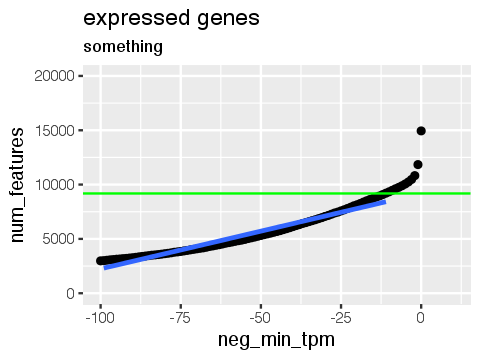

In [18]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(cbmtMatrix, aes(neg_min_tpm,num_features)) + 
    geom_point() +  
    scale_x_continuous(limits=c(-100,10)) + 
    scale_y_continuous(limits=c(0,20000)) + 
    geom_smooth(data=cbmt.sub, method = "lm") + 
    geom_hline(yintercept = 9185, colour = "green") + ggtitle("expressed genes", subtitle = "something")

Out of ~1500 genes, roughly 9000 should remain after filtering lowly expressed geenes. Filtering should be performed on subsetted matrices for each analysis later, but here's the filter applied on the whole matrix. First, obtain the counts per million "CPM" matrix: 

In [19]:
all.CPM <- cpm(countsMatrix)

For now, let's set the minimum CPM to 1, and generate a logical matrix for CPM > 1:

In [20]:
thresh <- all.CPM > 1

We would like to keep genes that have at least 2 TRUEs in each row of `thresh`:

In [21]:
keep <- rowSums(thresh) >= 2

Now we subset the rows of the counts matrix to keep genes that satisfy our filter, then check how many genes are left:

In [22]:
counts.keep <- countsMatrix[keep,]
dim(counts.keep)

[1] 10796    35

## Differential expression analysis

### Virgin tissue contrasts:

The goal of this part of the analysis is to identify transcripts that show tissue-biased expression. We'll set a stringent cut-off of log 2-fold and a _p_-value of 0.001. 

First we'll subset the count matrix to only include virgin tissue samples:

In [23]:
countsMatrix.virgin = subset(countsMatrix, select=grepl("^V", colnames(countsMatrix)))
head(countsMatrix.virgin)

,V_CR_1,V_CR_2,V_H_1,V_H_2,V_OV_1,V_OV_2,V_RT_1,V_RT_2,V_RT_3
FBgn0202928,3232.66,3082.93,3879.65,2595.06,1520.47,1293.97,1092.88,863.67,1396.54
FBgn0199886,0.00,0.00,5.05,5.10,0.00,0.00,0.00,0.00,0.00
FBgn0199563,520.27,645.77,442.95,353.21,689.31,570.83,631.27,559.54,715.31
FBgn0211236,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FBgn0206588,1251.06,929.85,1578.18,1563.96,3505.96,3700.23,1992.25,1559.37,2273.14
FBgn0211037,47.61,30.46,66.80,28.85,150.51,114.51,88.10,75.31,109.11


Now we can filter out low expression genes with a minimum 5 cpm cutoff:

In [24]:
cpmMatrix.virgin <- cpm(countsMatrix.virgin)
v.thresh <- cpmMatrix.virgin > 5
## look at number of columns with above requirements
table(rowSums(v.thresh))

v.keep <- rowSums(v.thresh) >= 3
countsMatrix.virgin.filt <- countsMatrix.virgin[v.keep,]
## Check how many genes remain in the matrix.
dim(countsMatrix.virgin.filt)


   0    1    2    3    4    5    6    7    8    9 
5057  167 1219  554  488  274  218  841  290 5836 

[1] 8501    9

The filtered matrix contains 9720 genes. Let's see what the # cpm cutoff corresponds to in counts (looking at just one of the samples):

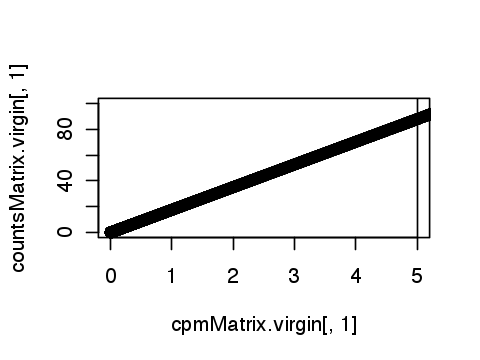

In [25]:
# Let's look at the first column
plot(cpmMatrix.virgin[,1],countsMatrix.virgin[,1],ylim=c(0,100),xlim=c(0,5))
# Add a vertical line at 5 CPM
abline(v=5)

Looks like 5 cpm corresponds to 60-100 mapped reads.

We'll also subset the `samplesData` object to only include the virgin tissue samples:

In [26]:
sampleInfo.v = subset(sampleInfo, Status == "virgin")
sampleInfo.v

,SampleName,Replicate,Tissue,Status,time
27,V_CR,V_CR_1,carcass,virgin,0hpm
28,V_CR,V_CR_2,carcass,virgin,0hpm
29,V_H,V_H_1,head,virgin,0hpm
30,V_H,V_H_2,head,virgin,0hpm
31,V_OV,V_OV_1,ovaries,virgin,0hpm
32,V_OV,V_OV_2,ovaries,virgin,0hpm
33,V_RT,V_RT_1,repTract,virgin,0hpm
34,V_RT,V_RT_2,repTract,virgin,0hpm
35,V_RT,V_RT_3,repTract,virgin,0hpm


We can now define groups for differential expression:

In [27]:
groups.v = factor(sampleInfo.v$Tissue)
design.v = model.matrix( ~ 0 + groups.v)
colnames(design.v) <- levels(groups.v)
rownames(design.v) <- sampleInfo.v$Replicate
design.v

,carcass,head,ovaries,repTract
V_CR_1,1,0,0,0
V_CR_2,1,0,0,0
V_H_1,0,1,0,0
V_H_2,0,1,0,0
V_OV_1,0,0,1,0
V_OV_2,0,0,1,0
V_RT_1,0,0,0,1
V_RT_2,0,0,0,1
V_RT_3,0,0,0,1


Now we'll create the `DGE` object and fit the general linear model:

In [28]:
dgeList.v <- DGEList(counts = countsMatrix.virgin.filt, group = groups.v)
dgeList.v <- calcNormFactors(dgeList.v)
dgeList.v <- estimateCommonDisp(dgeList.v)
dgeList.v <- estimateTagwiseDisp(dgeList.v)
dgeList.v_fit <- glmFit(dgeList.v, design.v)

We can add annotation information to the fit object, and slot it into the `genes` slot:

In [29]:
# Extract annotation for genes in the fit object
ann.v = subset(annot.sum, FBgn_ID %in% rownames(dgeList.v_fit))
# convert factors to characters
ann.v = data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.v = ann.v[match(rownames(dgeList.v_fit), ann.v$FBgn_ID),]
# convert factors to characters, again
ann.v <- data.frame(lapply(ann.v, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.v) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.v$GeneID==rownames(dgeList.v_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.v_fit$genes = ann.v


TRUE 
8501 

We can look at what's contained in the fit object

In [30]:
dgeList.v_fit

An object of class "DGEGLM"
$coefficients
               carcass       head    ovaries   repTract
FBgn0202928  -8.416901  -8.460380  -9.756967 -10.056022
FBgn0199563 -10.096278 -10.544873 -10.560267 -10.607022
FBgn0206588  -9.490043  -9.158122  -8.817965  -9.497544
FBgn0209112  -7.707808  -7.499406  -8.162127  -7.483879
FBgn0199619  -6.120271  -6.504968  -6.432740  -6.483691
8496 more rows ...

$fitted.values
               V_CR_1     V_CR_2      V_H_1      V_H_2     V_OV_1     V_OV_2
FBgn0202928  3432.083  2913.3191  3629.3632  2787.9223  1393.6185  1423.4661
FBgn0199563   639.973   543.2402   451.2934   346.6644   624.0497   637.4152
FBgn0206588  1173.479   996.1058  1806.3104  1387.5307  3564.3083  3640.6464
FBgn0209112  6974.600  5920.3794  9488.2002  7288.4314  6867.6877  7014.7754
FBgn0199619 34117.919 28960.9486 25648.7266 19702.2596 38715.1869 39544.3639
                V_RT_1     V_RT_2     V_RT_3
FBgn0202928  1099.2452   913.0754  1318.4846
FBgn0199563   633.5094   526.2173  

And look at a summary of tagwise disperion

In [31]:
summary(dgeList.v$tagwise.dispersion)

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
0.01758 0.02442 0.02920 0.04268 0.03762 1.80300 

We can plot the biological coefficient of variation to examine variability within each sample. It would also be useful to generatea `voom` object as an aside to check compare to the edgeR analyses (from this objectm we can look at the mean-variance trend). Also, let's generate a QQ-plot.

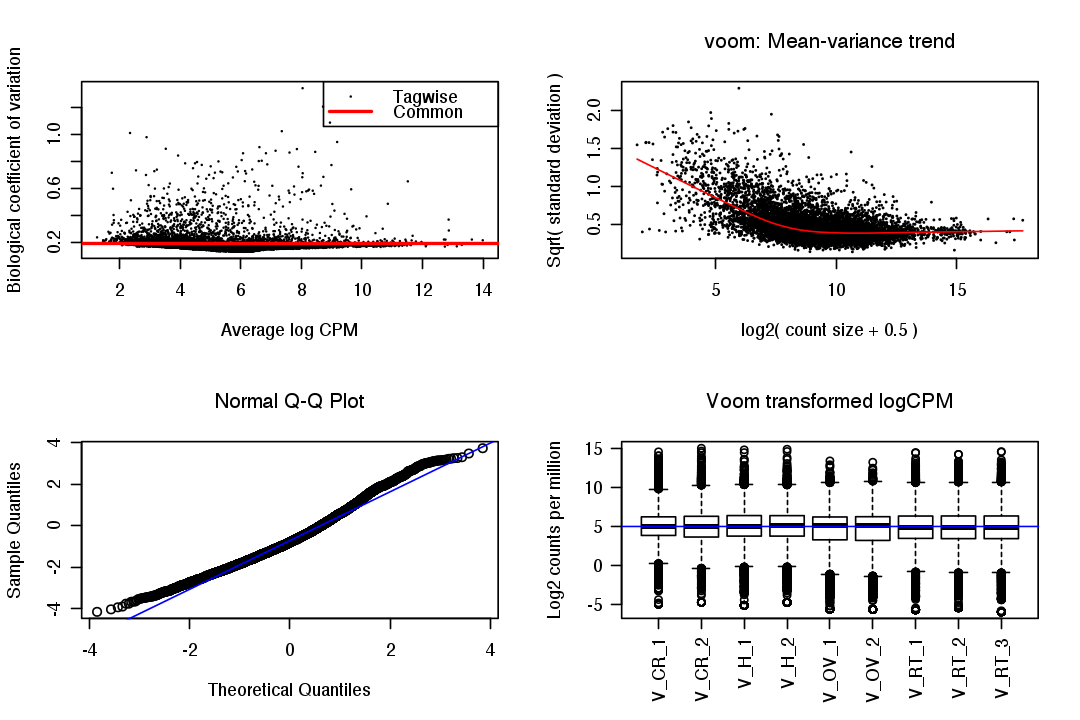

In [32]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.v)
# mean-variance trend
virgin.voom = voom(dgeList.v, design.v, plot=TRUE)
# QQ-plot
g.v <- gof(dgeList.v_fit)
z.v <- zscoreGamma(g.v$gof.statistics,shape=g.v$df/2,scale=2)
qqnorm(z.v); qqline(z.v, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(virgin.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(virgin.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try '`method = "bcv"`' for a different type of grouping):

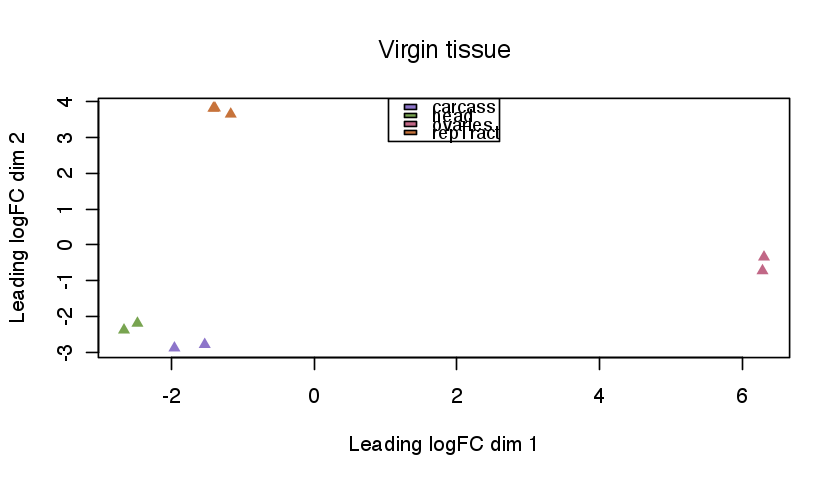

In [33]:
## colour samples by tissue-type
col.tissue <- c("#8d75ca","#78a450","#c16786","#c7733b")[sampleInfo.v$Tissue]
options(repr.plot.width = 7, repr.plot.height = 4)
plotMDS(dgeList.v, col=col.tissue, pch= 17, cex = 1)
legend("top",fill=c("#8d75ca","#78a450","#c16786","#c7733b"),legend=levels(sampleInfo.v$Tissue), cex = 0.85)
# Add a title
title("Virgin tissue")

Can also look at with Glimma:

In [34]:
glMDSPlot(dgeList.v, groups = dgeList.v$samples$group, labels = sampleInfo.v$Replicate)

Samples are grouping correctly, although the head and carcass samples appear to be fairly similar. Another way to look at grouping is by looking at sample correlations:

for plotting:: min.raw: 0.215679189957847 max.raw: 1


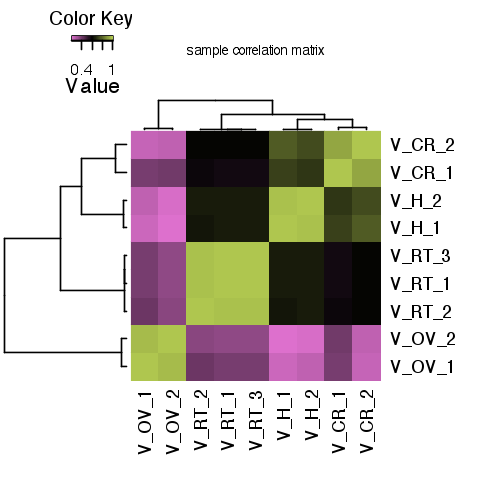

In [35]:
## Plot sample correlation
data = log2(countsMatrix.virgin.filt+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 4, repr.plot.height = 4)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

Finally, let's compare replicates within each sample using MA plots:

Warning message:
"Removed 9 rows containing missing values (position_stack)."Warning message:
"Removed 6 rows containing missing values (geom_point)."

Warning message:
"Removed 12 rows containing missing values (position_stack)."Warning message:
"Removed 31 rows containing missing values (geom_point)."

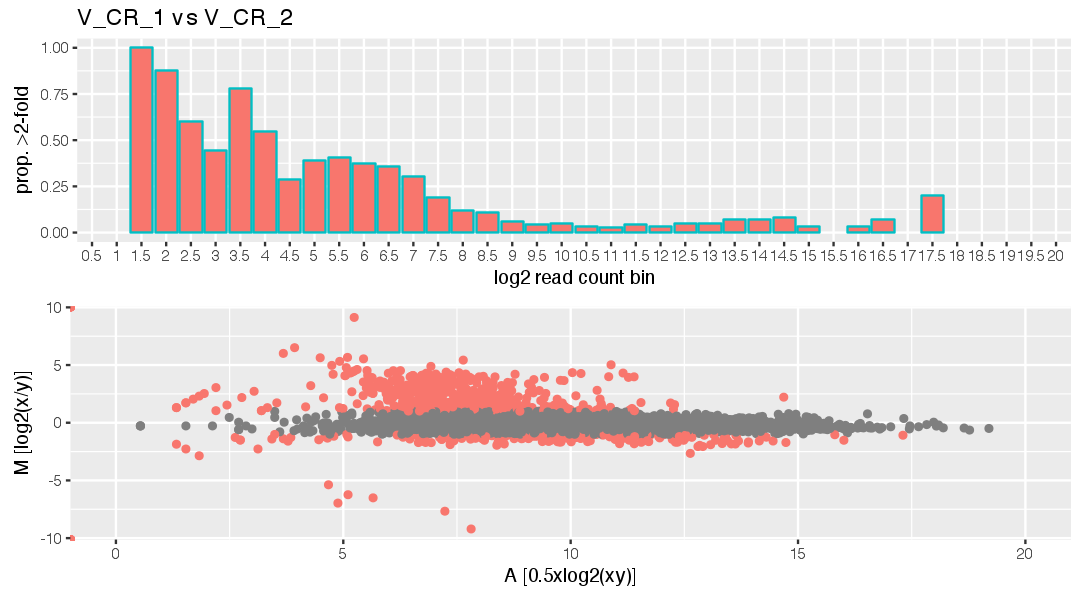

Warning message:
"Removed 10 rows containing missing values (position_stack)."Warning message:
"Removed 184 rows containing missing values (geom_point)."

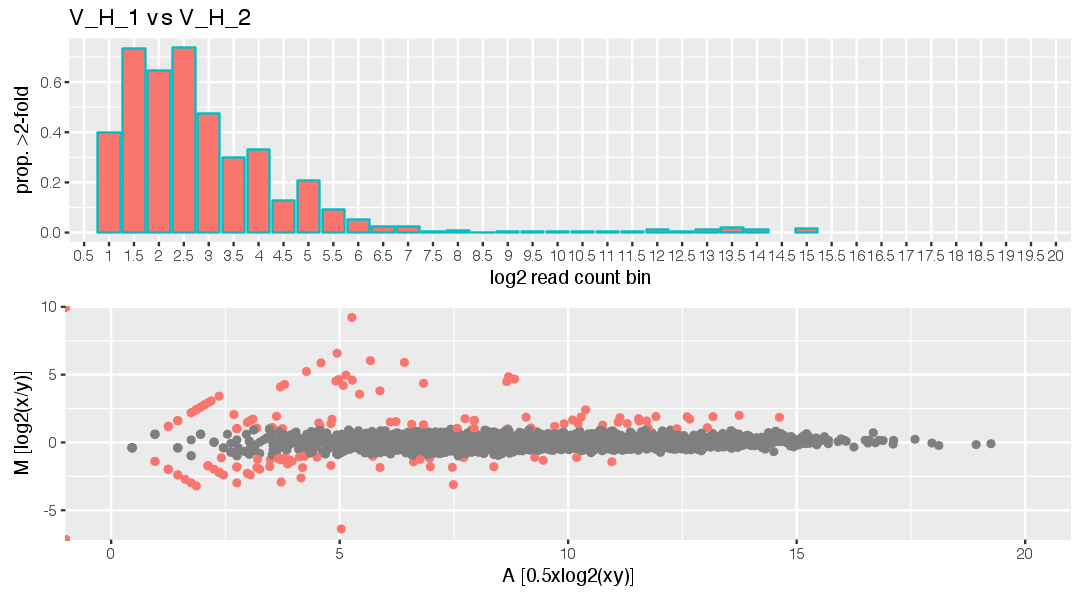

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 55 rows containing missing values (geom_point)."

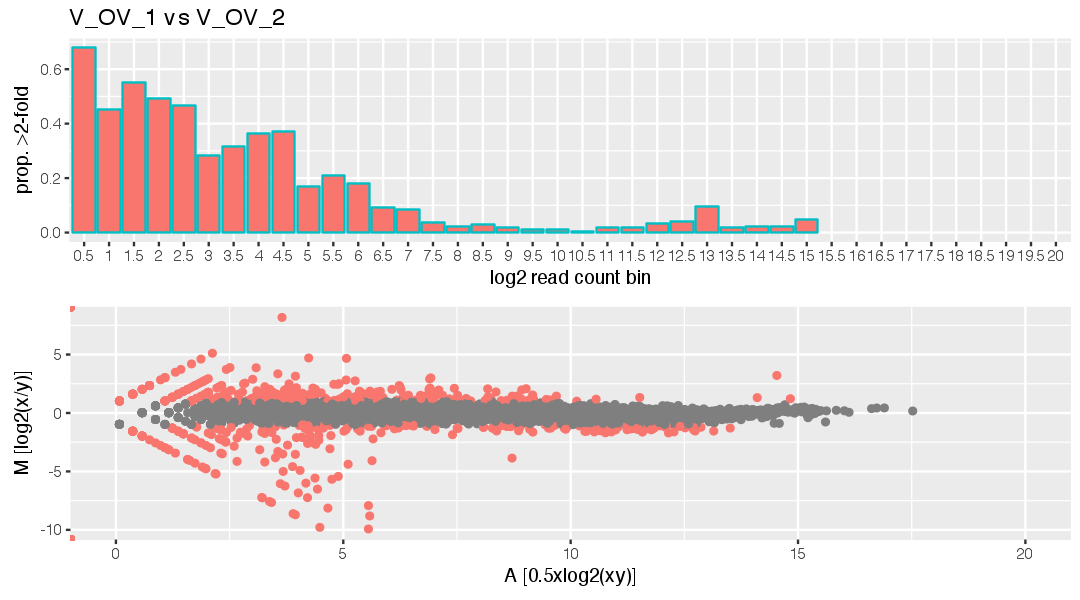

Warning message:
"Removed 15 rows containing missing values (position_stack)."Warning message:
"Removed 77 rows containing missing values (geom_point)."

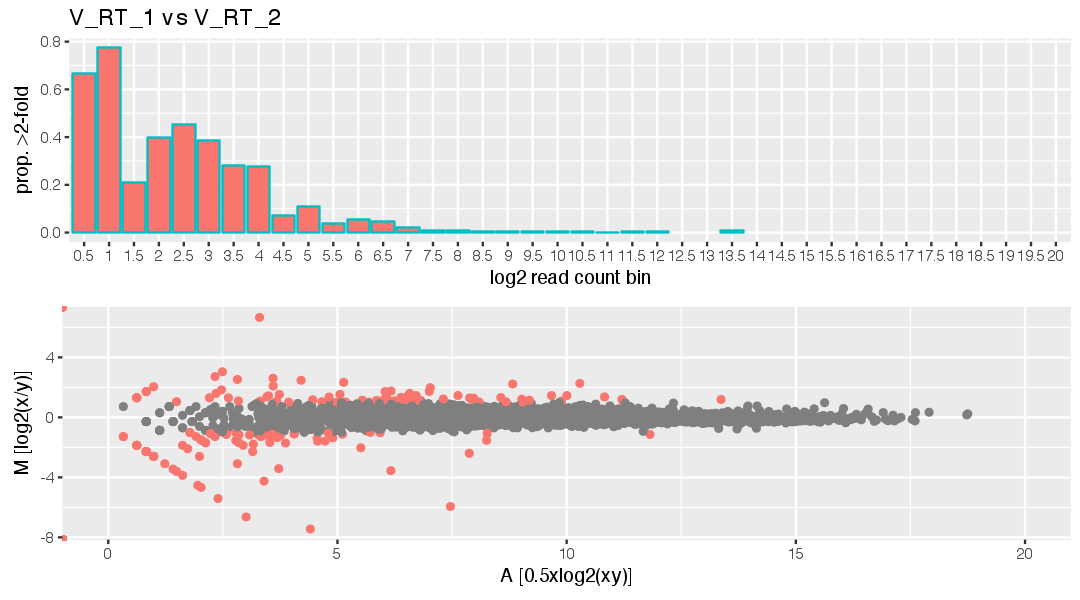

Warning message:
"Removed 17 rows containing missing values (position_stack)."Warning message:
"Removed 56 rows containing missing values (geom_point)."

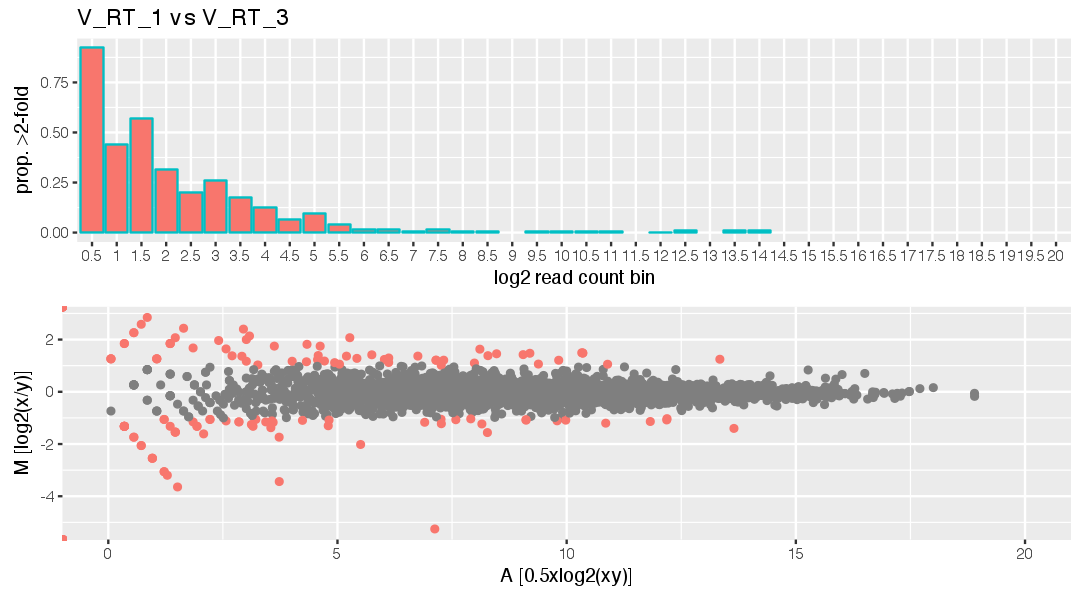

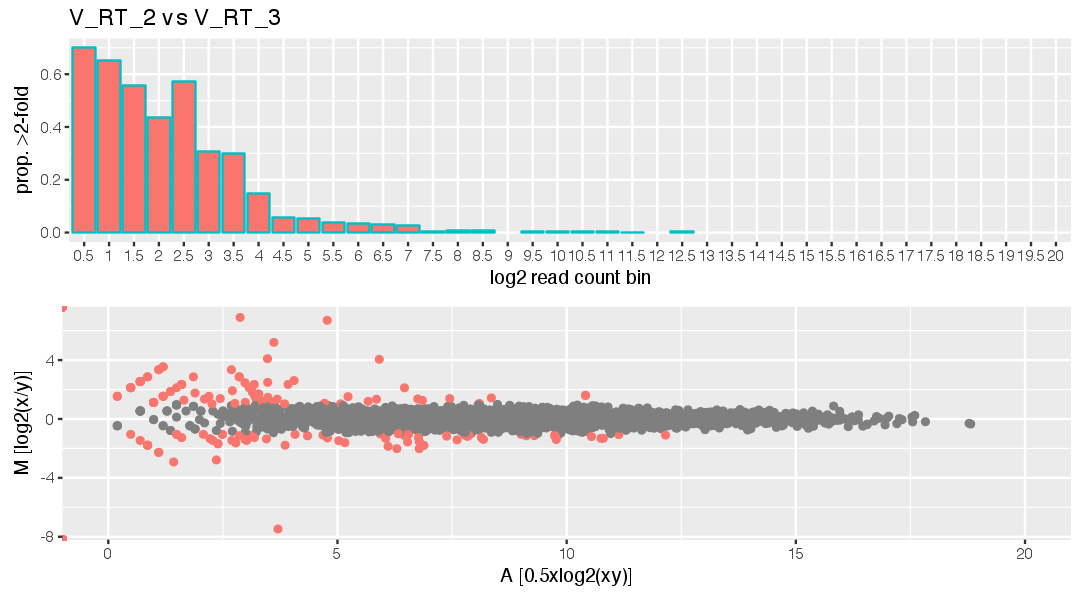

In [36]:
# normalize counts by the DESeq method (this is only used for these plots:
meta.v <- data.frame(row.names=colnames(countsMatrix.virgin.filt), condition=sampleInfo.v$Tissue)
countData.v<-round(countsMatrix.virgin.filt)
countData.v_normByDESeq = newCountDataSet(countData.v, meta.v)
countData.v_normByDESeq = estimateSizeFactors(countData.v_normByDESeq)
countData.v_normByDESeq = data.frame(counts(countData.v_normByDESeq, normalized=T))

options(repr.plot.width = 9, repr.plot.height = 5)
MA_BPlot(countData.v_normByDESeq, "V_CR_1", "V_CR_2")
MA_BPlot(countData.v_normByDESeq, "V_H_1", "V_H_2")
MA_BPlot(countData.v_normByDESeq, "V_OV_1", "V_OV_2")
MA_BPlot(countData.v_normByDESeq, "V_RT_1", "V_RT_2")
MA_BPlot(countData.v_normByDESeq, "V_RT_1", "V_RT_3")
MA_BPlot(countData.v_normByDESeq, "V_RT_2", "V_RT_3")

Now we can identify genes that show tissue-biased expression. First, we define the relevant contrasts. We'll need to define a set of three contrasts for each tissue:

In [37]:
cont.v.repTract <- makeContrasts(V_RT.vs.V_CR=repTract-carcass,
                                 V_RT.vs.V_HD=repTract-head,
                                 V_RT.vs.V_OV=repTract-ovaries,
                                 levels=design.v)
cont.v.ovaries <- makeContrasts(V_OV.vs.V_CR=ovaries-carcass,
                                V_OV.vs.V_HD=ovaries-head,
                                V_OV.vs.V_RT=ovaries-repTract,
                                levels=design.v)
cont.v.head <- makeContrasts(V_H.vs.V_CR=head-carcass,
                             V_H.vs.V_OV=head-ovaries,
                             V_H.vs.V_RT=head-repTract,
                             levels=design.v)

Now we can fit the negative binomial log-linear model to conduct gene-wise statistical tests. For each contrast, we will extract the table with the relevant DE stats.

###### Reproductive tract:

In [38]:
lrt.v.repTract <- glmLRT(dgeList.v_fit, contrast = cont.v.repTract)
lrt.v.repTract.tTags <- topTags(lrt.v.repTract, n = NULL)
lrt.v.repTract.tTags.table <- lrt.v.repTract.tTags$table
repTract.list<-subset(lrt.v.repTract.tTags.table, logFC.V_RT.vs.V_CR > 2 & logFC.V_RT.vs.V_HD > 2 & logFC.V_RT.vs.V_OV > 2 & FDR<0.001)$GeneID
length(repTract.list)
head(lrt.v.repTract.tTags.table)

[1] 263

,GeneID,gene_name,SwissProt_BlastX_Description,logFC.V_RT.vs.V_CR,logFC.V_RT.vs.V_HD,logFC.V_RT.vs.V_OV,logCPM,LR,PValue,FDR
390,FBgn0282588,GJ26319,.,17.13546,20.91091,16.91645,11.962427,2342.888,0,0
4995,FBgn0282566,GJ26297,Collagenase,15.88683,14.99110,16.59665,11.041991,2103.295,0,0
1590,FBgn0282309,GJ26040,.,15.51632,15.51632,15.51632,6.574363,1804.216,0,0
306,FBgn0208695,GJ21575,Trypsin epsilon,15.04328,16.57057,17.13029,10.668583,2014.518,0,0
8342,FBgn0282971,GJ26702,.,15.02306,15.03956,20.61957,11.671163,1555.868,0,0
2685,FBgn0282487,GJ26218,.,15.02064,18.26243,14.85952,9.314852,1921.859,0,0


##### Ovaries:

In [50]:
lrt.v.ovaries <- glmLRT(dgeList.v_fit, contrast = cont.v.ovaries)
lrt.v.ovaries.tTags <- topTags(lrt.v.ovaries, n = NULL)
lrt.v.ovaries.tTags.table <- lrt.v.ovaries.tTags$table
ovaries.list<-subset(lrt.v.ovaries.tTags.table, logFC.V_OV.vs.V_CR > 2 & logFC.V_OV.vs.V_HD > 2 & logFC.V_OV.vs.V_RT > 2 & FDR<0.001)$GeneID
length(ovaries.list)
head(lrt.v.ovaries.tTags.table)

[1] 560

,GeneID,gene_name,SwissProt_BlastX_Description,logFC.V_OV.vs.V_CR,logFC.V_OV.vs.V_HD,logFC.V_OV.vs.V_RT,logCPM,LR,PValue,FDR
6910,FBgn0282253,GJ25984,"Sarcoplasmic calcium-binding protein, alpha-B and -A chains",-12.471996,-6.141888,1.4767777,8.676713,1576.594,0,0
4943,FBgn0210847,GJ23750,Uncharacterized family 31 glucosidase KIAA1161,-11.817438,-4.357150,-2.5082501,8.754581,1710.916,0,0
3157,FBgn0200835,GJ13613,Glutamate decarboxylase,-10.966609,-13.780782,-0.2926256,6.715479,1637.175,0,0
7437,FBgn0208853,GJ21734,.,-10.618424,-15.106918,-7.3598225,5.638139,1581.591,0,0
771,FBgn0199951,GJ12715,Acetylcholine receptor subunit beta-like 1,-9.997938,-13.465656,0.4946024,6.332240,1816.113,0,0
214,FBgn0206119,GJ18973,Low-density lipoprotein receptor-related protein 4,-9.990644,-13.772843,-4.7873756,6.460717,1779.132,0,0


##### Head:

In [40]:
lrt.v.head <- glmLRT(dgeList.v_fit, contrast = cont.v.head)
lrt.v.head.tTags <- topTags(lrt.v.head, n = NULL)
lrt.v.head.tTags.table <- lrt.v.head.tTags$table
head.list<-subset(lrt.v.head.tTags.table, logFC.V_H.vs.V_CR > 2 & logFC.V_H.vs.V_OV > 2 & logFC.V_H.vs.V_RT > 2 & FDR<0.001)$GeneID
length(head.list)
head(lrt.v.head.tTags.table)

[1] 264

,GeneID,gene_name,SwissProt_BlastX_Description,logFC.V_H.vs.V_CR,logFC.V_H.vs.V_OV,logFC.V_H.vs.V_RT,logCPM,LR,PValue,FDR
4943,FBgn0210847,GJ23750,Uncharacterized family 31 glucosidase KIAA1161,-7.460288,4.357150,1.848900,8.754581,1710.916,0,0
4526,FBgn0201683,GJ14472,Guanine nucleotide-binding protein subunit gamma-e,7.247038,9.175192,8.505554,7.816941,1770.897,0,0
6910,FBgn0282253,GJ25984,"Sarcoplasmic calcium-binding protein, alpha-B and -A chains",-6.330108,6.141888,7.618666,8.676713,1576.594,0,0
5255,FBgn0204002,GJ16823,"., Double C2-like domain-containing protein beta",5.303874,9.490475,8.281073,5.878782,1643.372,0,0
178,FBgn0208828,GJ21709,Probable cytochrome P450 4e1,5.254805,12.017922,7.699930,6.135289,1544.162,0,0
4250,FBgn0198655,GJ11397,.,4.721341,2.048730,-6.531974,5.938365,1589.547,0,0


We can generate a tissue-biased factor table to annotate a simple heatmap of the tissue-biased genes (this can also be used for GO analysis later):

In [41]:
RT_factors = as.data.frame(repTract.list)
RT_factors$V1 = "RT-biased"
rownames(RT_factors) = repTract.list
RT_factors = subset(RT_factors, select = "V1")

OV_factors = as.data.frame(ovaries.list)
OV_factors$V1 = "OV-biased"
rownames(OV_factors) = ovaries.list
OV_factors = subset(OV_factors, select = "V1")

H_factors = as.data.frame(head.list)
H_factors$V1 = "H-biased"
rownames(H_factors) = head.list
H_factors = subset(H_factors, select = "V1")

virgin.factor.labeling = rbind(RT_factors, OV_factors, H_factors)
colnames(virgin.factor.labeling) = c('tissue_bias')
virgin.factor_list = unique(virgin.factor.labeling[,1])

For a heatmap, we'll subset from the mean TPM matrix produced in the introduction:

In [42]:
tissueBiased.meanTPM = subset(meanTPMmatrix, rownames(meanTPMmatrix) %in% rownames(virgin.factor.labeling))
tissueBiased.meanTPM.v = subset(tissueBiased.meanTPM, select=grepl("^V", colnames(tissueBiased.meanTPM)))

Some more bells and whistles to generate the heatmap (for now with heatmap.3, fix this later and use the heatmap3 package):

In [43]:
data = tissueBiased.meanTPM.v
gene_factors = unique(virgin.factor.labeling[,1])
gene_factor_colors = rainbow(length(gene_factors))
names(gene_factor_colors) = gene_factors
data = log2(data+1)
data = as.matrix(data) # convert to matrix
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')
gene_cor = NULL
if (is.null(gene_cor)) { gene_cor = cor(t(data), method='pearson', use='pairwise.complete.obs') }
gene_dist = as.dist(1-gene_cor)
hc_genes = hclust(gene_dist, method='complete')
myheatcol = colorpanel(75, '#f8e95a','black','#e1526d')
data = t(scale(t(data), scale=F)) # center rows, mean substracted
heatmap_data = data
gene_factor_row_vals = as.factor(virgin.factor.labeling[rownames(heatmap_data),])
names(gene_factor_row_vals) = rownames(heatmap_data)
gene_factors_here = unique(gene_factor_row_vals)
names(gene_factors_here) = gene_factors_here
num_gene_factors_here = length(gene_factors_here)
geneFactorColors = c("#e1526d", "#b85516", "#647700")
geneFactorAnnotations = matrix(nrow=nrow(heatmap_data), ncol=num_gene_factors_here)
for (i in 1:num_gene_factors_here) {
    geneFactorAnnotations[,i] = gene_factor_row_vals %in% gene_factors_here[i]
}
geneFactorAnnotations = apply(geneFactorAnnotations, 1:2, function(x) as.logical(x))
geneFactorAnnotations = t(sample_matrix_to_color_assignments(t(geneFactorAnnotations), col=geneFactorColors))
rownames(geneFactorAnnotations) = rownames(heatmap_data)
colnames(geneFactorAnnotations) = gene_factors_here
heatmap_data[heatmap_data < -2] = -2
heatmap_data[heatmap_data > 2] = 2

Now we plot it:

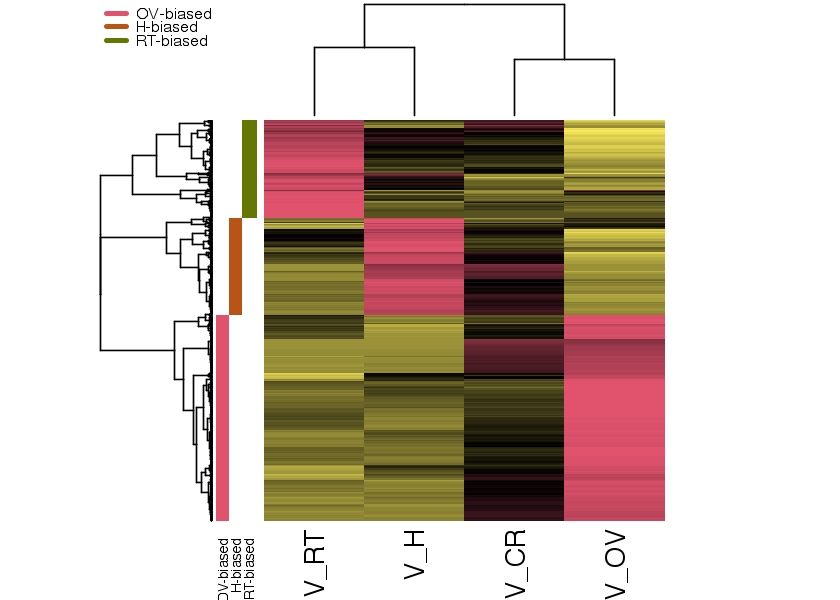

In [44]:
options(repr.plot.width = 7, repr.plot.height = 5)
heatmap3(heatmap_data, 
         col=myheatcol, 
         cexCol = 2, 
         labRow = "", 
         legendfun=function() showLegend(legend=c("OV-biased", "H-biased", "RT-biased"), col=c("#e1526d", "#b85516", "#647700")), 
        cex.main=0.75, 
             RowSideColors = geneFactorAnnotations)

Another way to capture tissue-biased genes is by calculating tissue specificity:

In [51]:
virginSpecificity = as.data.frame(calcSpecificity(tissueBiased.meanTPM.v))
head(virginSpecificity)

,V_CR,V_H,V_OV,V_RT
FBgn0013068,0.1769283,0.15889836,0.4530102,0.22118996
FBgn0013069,0.3177965,0.10598707,0.4127945,0.16416602
FBgn0013070,0.2909291,0.08853269,0.4449854,0.17008264
FBgn0013071,0.3142303,0.10309193,0.4242000,0.15629745
FBgn0013097,0.2467089,0.24507473,0.3180712,0.22408713
FBgn0013104,0.3253083,0.02202631,0.5295902,0.05030511


We can ask: how does tissue specificity correlate with normalized expression?

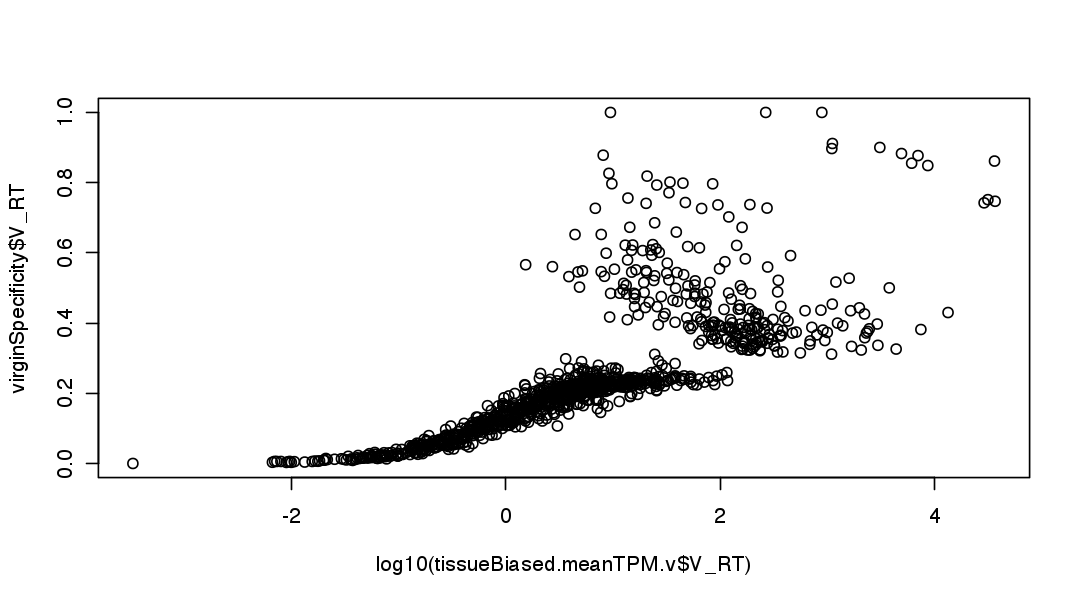

In [52]:
plot(x=log10(tissueBiased.meanTPM.v$V_RT), y=virginSpecificity$V_RT)

One plot we can generate is how these tissue biased transcripts correspond to mean Ka/Ks across the virilis group. We can plat this as points along the chromosomes. First, create a tissue-biased gene matrix.

In [46]:
tissueBiased.meanTPM.v2 = tissueBiased.meanTPM.v
tissueBiased.meanTPM.v2$FBgn_ID = row.names(tissueBiased.meanTPM.v)
rownames(tissueBiased.meanTPM.v2) = NULL

## modefiy the factor labeling to merge with expression data:
virgin.factor.labeling.v = virgin.factor.labeling
virgin.factor.labeling.v$FBgn_ID = rownames(virgin.factor.labeling)

Now generate a data frame with tissue-biased gene info, PAML data and coordinate information:

In [47]:
tmpDF1 = merge(tissueBiased.meanTPM.v2, virgin.factor.labeling.v, all=TRUE)
tmpDF2 = subset(paml.data, FBgn_ID %in% tmpDF1$FBgn_ID & omega < 800 & grepl("Chr", chromosome))
tissBiased.paml.data  = merge (tmpDF1, tmpDF2)

Plot it:

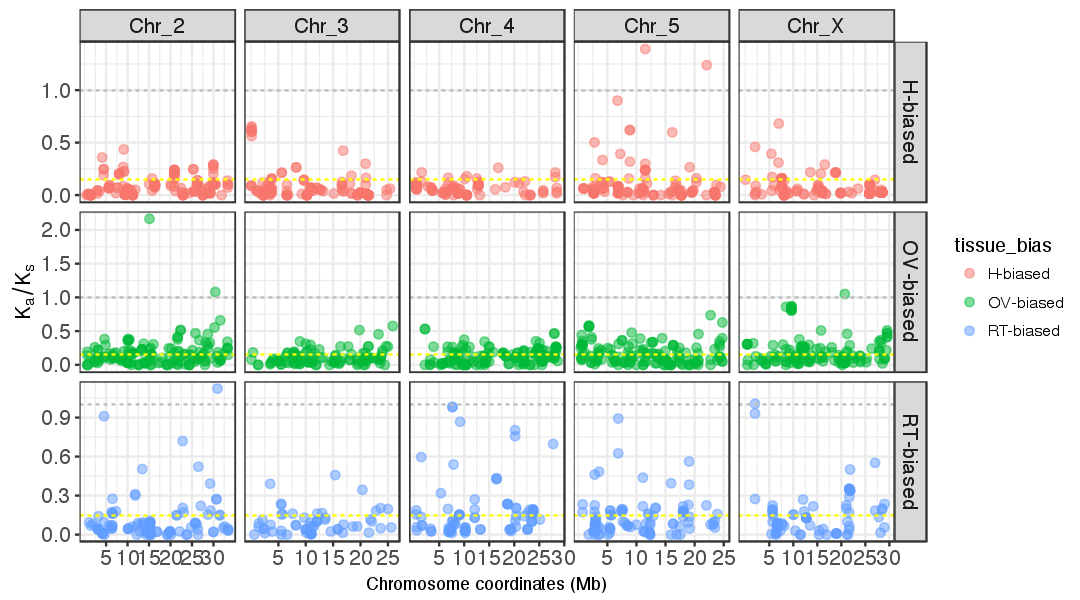

In [48]:
options(repr.plot.width = 9, repr.plot.height = 5)
ggplot(subset(tissBiased.paml.data, chromosome != "Chr_6"), aes(max, omega, colour = tissue_bias)) + 
    geom_point(size=2, alpha=0.5) + 
    geom_hline(yintercept = 0.15, linetype="dashed", colour = "yellow") + 
    geom_hline(yintercept = 1, linetype="dashed", colour = "gray")  + 
    facet_grid(tissue_bias~chromosome, scales = "free") +
    scale_x_continuous(breaks=seq(5000000,30000000,5000000), labels=expression("5", "10", "15", "20", "25", "30")) + 
    xlab ("Chromosome coordinates (Mb)") + 
    labs(y=expression(K[a]/K[s])) + 
    theme_bw() +
    theme(axis.title.x = element_text(face = "bold", size = 10, vjust=0.1), axis.text.x=element_text(face = "bold", size = 12),axis.text.y = element_text(face = "bold", size = 12), axis.title.y = element_text(face = "bold.italic", size = 12, vjust=0.1), strip.text=element_text(face="bold", size = 12))

Several RT-biasaed genes shw elevated Ka/Ks. Will follow up on this later.

#### Gene Ontology analysis

Need gene length information and GO annotation files for GOseq:

In [53]:
gene_lengths = read.table("GO.analysis/FBgn_lengths.txt", header=T, row.names=1)
gene_lengths = as.matrix(gene_lengths[,1,drop=F])
GO_info = read.table("GO.analysis/Trinotate_report_dvir1.06_gene_ontology.txt", header=F, row.names=1,stringsAsFactors=F)
GO_info_listed = apply(GO_info, 1, function(x) unlist(strsplit(x,',')))
names(GO_info_listed) = rownames(GO_info)
features_with_GO = rownames(GO_info)
lengths_features_with_GO = gene_lengths[features_with_GO,]
get_GO_term_descr =  function(x) {
    d = 'none';
    go_info = GOTERM[[x]];
    if (length(go_info) >0) { d = paste(Ontology(go_info), Term(go_info), sep=' ');}
    return(d);
}

We'll process some of this and come up with the null expectation for GO terms, then plot the proportion of tissue-biased genes as a function of those biased in bins of 200:

Warning message in pcls(G):
"initial point very close to some inequality constraints"

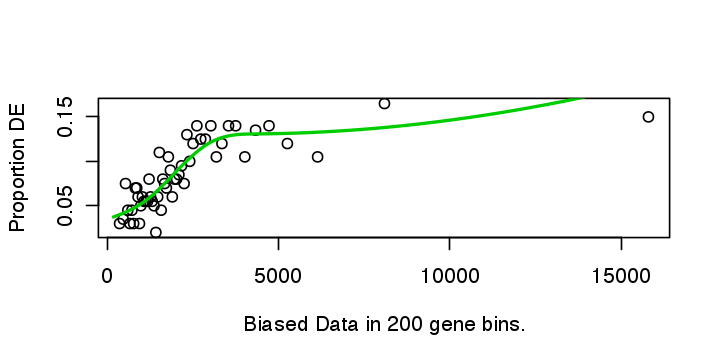

In [55]:
# build pwf based on ALL DE features
options(repr.plot.width = 6, repr.plot.height = 3)

cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling))
pwf=nullp(cat_genes_vec,bias.data=lengths_features_with_GO)
rownames(pwf) = names(GO_info_listed)

That looks fine. Now we'll process each tissue biased category of genes in a for-loop to identify enriched GO terms and their FDR values:

In [60]:
GO_enriched_list = list()

for (feature_cat in virgin.factor_list) {
    message('Processing category: ', feature_cat)
    cat_genes_vec = as.integer(features_with_GO %in% rownames(virgin.factor.labeling.v)[virgin.factor.labeling.v$tissue_bias == feature_cat])
    pwf$DEgenes = cat_genes_vec
    res = goseq(pwf,gene2cat=GO_info_listed)
    ## over-represented categories:
    pvals = res$over_represented_pvalue
    pvals[pvals > 1 -1e-10] = 1-1e-10
    q = qvalue(pvals)
    res$over_represented_FDR = q$qvalues
    go_enrich_factor = feature_cat
    enrich_result_table = res[res$over_represented_pvalue<=0.05,]
    descr = unlist(lapply(enrich_result_table$category, get_GO_term_descr))
    enrich_result_table$go_term = descr
    enrich_result_table$factor = go_enrich_factor
    GO_enriched_list[[feature_cat]] = enrich_result_table
}

GO_enrichment_data = rbindlist(GO_enriched_list)

Processing category: RT-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: OV-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns
Processing category: H-biased
Using manually entered categories.
Calculating the p-values...
'select()' returned 1:1 mapping between keys and columns


The results are saved in `GO_enrichment_data`. We can take a look at the output format. Here's an example of how to plot it (for the RT-biased category):

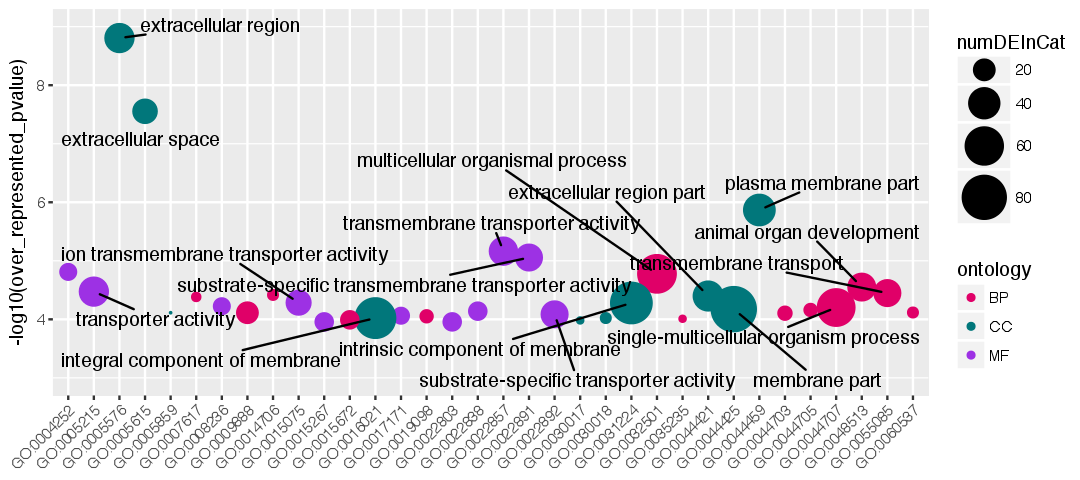

In [63]:
### RT plot
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(subset(GO_enrichment_data, over_represented_FDR < 0.05 & factor == "RT-biased"), 
       aes(category, -log10(over_represented_pvalue), size = numDEInCat, colour = ontology)) + 
    geom_point()  + 
    xlab(NULL) + 
    geom_text_repel(data = subset(GO_enrichment_data, factor == "RT-biased" & over_represented_FDR < 0.05 & numDEInCat > 20), 
                    aes(category, -log10(over_represented_pvalue),label=term), 
                    force = 8, 
                    inherit.aes = F, 
                    box.padding = unit(0.35, "lines"), 
                    point.padding = unit(0.5, "lines"), 
                    fontface = "bold", 
                    size = 4) + 
    theme(axis.text.x = element_text(angle = 45, face = "bold", vjust = 1, hjust = 1)) + 
    scale_size(range = c(0,12)) + 
    scale_colour_manual(values=c("#e00068",
                                 "#01777b",
                                 "#9d31e4")) + 
    scale_y_continuous(limits=c(3, 9))

## Reproductive tract post-mating contrasts:

POSTHOC: the QC analysis revealed two rogue replicates that should be removed:

In [160]:
## Define good replicates
RT_GoodReps = as.character(subset(sampleInfo.pm, Replicate != "H3_RT_1" & Replicate != "H6_RT_1")$Replicate)
RT_GoodReps

[1] "C12_RT_1" "C12_RT_2" "C12_RT_3" "C3_RT_1"  "C3_RT_2"  "C3_RT_3" 
 [7] "C6_RT_1"  "C6_RT_2"  "C6_RT_3"  "H12_RT_1" "H12_RT_2" "H12_RT_3"
[13] "H3_RT_2"  "H3_RT_3"  "H6_RT_2"  "H6_RT_3"  "V_RT_1"   "V_RT_2"  
[19] "V_RT_3"

Create RT-specific count matrix 

In [161]:
countsMatrix.pm = subset(countsMatrix, select=grepl("RT", colnames(countsMatrix)))
countsMatrix.pm = subset(countsMatrix.pm, select=RT_GoodReps)
head(countsMatrix.pm)

,C12_RT_1,C12_RT_2,C12_RT_3,C3_RT_1,C3_RT_2,C3_RT_3,C6_RT_1,C6_RT_2,C6_RT_3,H12_RT_1,H12_RT_2,H12_RT_3,H3_RT_2,H3_RT_3,H6_RT_2,H6_RT_3,V_RT_1,V_RT_2,V_RT_3
FBgn0202928,435.52,541.22,553.43,380.65,534.23,466.21,591.86,731.63,433.42,854.99,943.25,691.22,467.27,994.93,1023.68,646.37,1092.88,863.67,1396.54
FBgn0199886,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FBgn0199563,298.09,479.05,462.67,318.37,358.64,348.37,401.97,536.98,392.55,701.70,792.18,576.08,439.20,761.34,906.30,451.57,631.27,559.54,715.31
FBgn0211236,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
FBgn0206588,945.11,1517.41,1416.42,1005.06,1266.19,1489.42,1563.00,1620.62,1347.77,2444.35,2675.51,1962.39,1798.57,3041.42,3692.64,1336.11,1992.25,1559.37,2273.14
FBgn0211037,32.17,41.24,49.99,44.35,24.76,52.49,38.50,48.85,47.78,76.72,88.37,63.45,53.33,103.38,96.71,37.04,88.10,75.31,109.11


Now let's filter low expression genes within a minimum cpm of 5:

In [162]:
cpmMatrix.pm <- cpm(countsMatrix.pm)
pm.thresh <- cpmMatrix.pm > 5
## look at number of columns with above requirements
table(rowSums(pm.thresh))

pm.keep <- rowSums(pm.thresh) >= 3
countsMatrix.pm.filt <- countsMatrix.pm[pm.keep,]
## Check how many genes remain in the matrix.
dim(countsMatrix.pm.filt)


   0    1    2    3    4    5    6    7    8    9   10   11   12   13   14   15 
7066  143   69   57   46   49   35   35   44   28   25   30   35   38   45   47 
  16   17   18   19 
  68   77   98 6909 

[1] 7666   19

Let's see what the cpm cutoff corresponds to in raw counts:

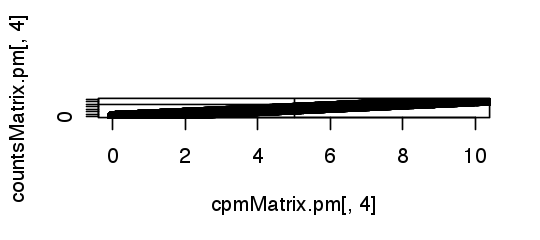

In [165]:
# Let's look at the first column
plot(cpmMatrix.pm[,4],countsMatrix.pm[,4],ylim=c(0,140),xlim=c(0,10))
# Add a vertical line at 5 CPM
abline(v=5, h = 100)

5 cpm roughly corresponds to ~100 mapped reads/transcript.

We'll also subset the `samplesInfo` object to only include the RT samples:

In [166]:
sampleInfo.pm = subset(sampleInfo, Tissue == "repTract")
# remove rogue replicates:
sampleInfo.pm = subset(sampleInfo.pm, Replicate != "H3_RT_1" & Replicate != "H6_RT_1")
sampleInfo.pm

,SampleName,Replicate,Tissue,Status,time
1,C12_RT,C12_RT_1,repTract,conspecific,12hpm
2,C12_RT,C12_RT_2,repTract,conspecific,12hpm
3,C12_RT,C12_RT_3,repTract,conspecific,12hpm
4,C3_RT,C3_RT_1,repTract,conspecific,3hpm
5,C3_RT,C3_RT_2,repTract,conspecific,3hpm
6,C3_RT,C3_RT_3,repTract,conspecific,3hpm
11,C6_RT,C6_RT_1,repTract,conspecific,6hpm
12,C6_RT,C6_RT_2,repTract,conspecific,6hpm
13,C6_RT,C6_RT_3,repTract,conspecific,6hpm
14,H12_RT,H12_RT_1,repTract,heterospecific,12hpm


There are several ways in which a design matrix can be made depending on which comparisons should be made. We'll work through all possibilities, starting with the boradest groupings up to the narrowest, pair-wise comparisons. These comparisons will be:
1. Compare postmating against virgin (virgin as control)
2. Compare heterospecific to conspecific
3. ....

(complete the list later)

#### 1. Comparing postmating samples to virgin:

We'll first define the relevant groups for this comparison, making the `virgin` sample the control:

In [167]:
## Will need to relevel the Status grouping to make virgin control
sampleInfo.pm$Status <- relevel(sampleInfo.pm$Status, ref = "virgin")
groups.pm.1 <- factor(sampleInfo.pm$Status)
design.pm.1 <- model.matrix(~groups.pm.1)
colnames(design.pm.1) <- levels(groups.pm.1)
rownames(design.pm.1) <- sampleInfo.pm$Replicate
head(design.pm.1)

,virgin,conspecific,heterospecific
C12_RT_1,1,1,0
C12_RT_2,1,1,0
C12_RT_3,1,1,0
C3_RT_1,1,1,0
C3_RT_2,1,1,0
C3_RT_3,1,1,0


Create edgeR DE object and run glmFit

In [168]:
dgeList.pm.1 <- DGEList(counts = countsMatrix.pm.filt, group = groups.pm.1)
dgeList.pm.1 <- calcNormFactors(dgeList.pm.1)
dgeList.pm.1 <- estimateCommonDisp(dgeList.pm.1)
dgeList.pm.1 <- estimateTagwiseDisp(dgeList.pm.1)
dgeList.pm.1_fit <- glmFit(dgeList.pm.1, design.pm.1)

Let's add the annotation information to this fir object:

In [169]:
# Extract annotation for genes in the fit object
ann.pm.1 = subset(annot.sum, FBgn_ID %in% rownames(dgeList.pm.1_fit))
# convert factors to characters
ann.pm.1 = data.frame(lapply(ann.pm.1, as.character), stringsAsFactors=FALSE)
# align the fit object's rownames with gene ID's
ann.pm.1 = ann.pm.1[match(rownames(dgeList.pm.1_fit), ann.pm.1$FBgn_ID),]
# convert factors to characters, again
ann.pm.1 <- data.frame(lapply(ann.pm.1, as.character), stringsAsFactors=FALSE)
# Rename "FBgn_ID" as "GeneID"
colnames(ann.pm.1) = c ("GeneID", "gene_name", "SwissProt_BlastX_Description")
# Check that the fit rownames match the annotation file's gene ID's
table(ann.pm.1$GeneID==rownames(dgeList.pm.1_fit))
# Add the annotations to the fit object in the "genes" slot
dgeList.pm.1_fit$genes = ann.pm.1


TRUE 
7666 

We can check what's contained in the fit object:

In [170]:
dgeList.pm.1_fit

An object of class "DGEGLM"
$coefficients
                virgin conspecific heterospecific
FBgn0202928 -10.168532 -0.23131150   -0.363116914
FBgn0199563 -10.720343  0.05998423   -0.009608735
FBgn0206588  -9.610128  0.16996758    0.169600584
FBgn0209112  -7.596737 -0.31366140   -0.278364782
FBgn0199619  -6.596503 -0.01059940   -0.058469770
7661 more rows ...

$fitted.values
              C12_RT_1   C12_RT_2   C12_RT_3    C3_RT_1    C3_RT_2    C3_RT_3
FBgn0202928   389.5526   587.7604   558.5756   401.3062   466.5697   512.3523
FBgn0199563   300.1951   452.9370   430.4468   309.2526   359.5456   394.8264
FBgn0206588  1017.1789  1534.7283  1458.5225  1047.8692  1218.2815  1337.8268
FBgn0209112  4696.6380  7086.3283  6734.4618  4838.3449  5625.1930  6177.1714
FBgn0199619 17290.4419 26087.9692 24792.5901 17812.1288 20708.8713 22740.9528
               C6_RT_1    C6_RT_2    C6_RT_3   H12_RT_1   H12_RT_2   H12_RT_3
FBgn0202928   611.2958   687.7131   461.5060   867.4712   950.8457   676.6415

Also, check the tagwise dispersion summary:

In [171]:
summary(dgeList.pm.1$tagwise.dispersion)

    Min.  1st Qu.   Median     Mean  3rd Qu.     Max. 
0.006767 0.011340 0.015070 0.025310 0.022250 1.523000 

Looks decent. Now let's the biological coefficient of variation to examine variability within each sample. It would also be useful to generate a voom object as an aside to compare to the edgeR analyses (from this object we can look at the mean-variance trend). Also, let's generate a QQ-plot.

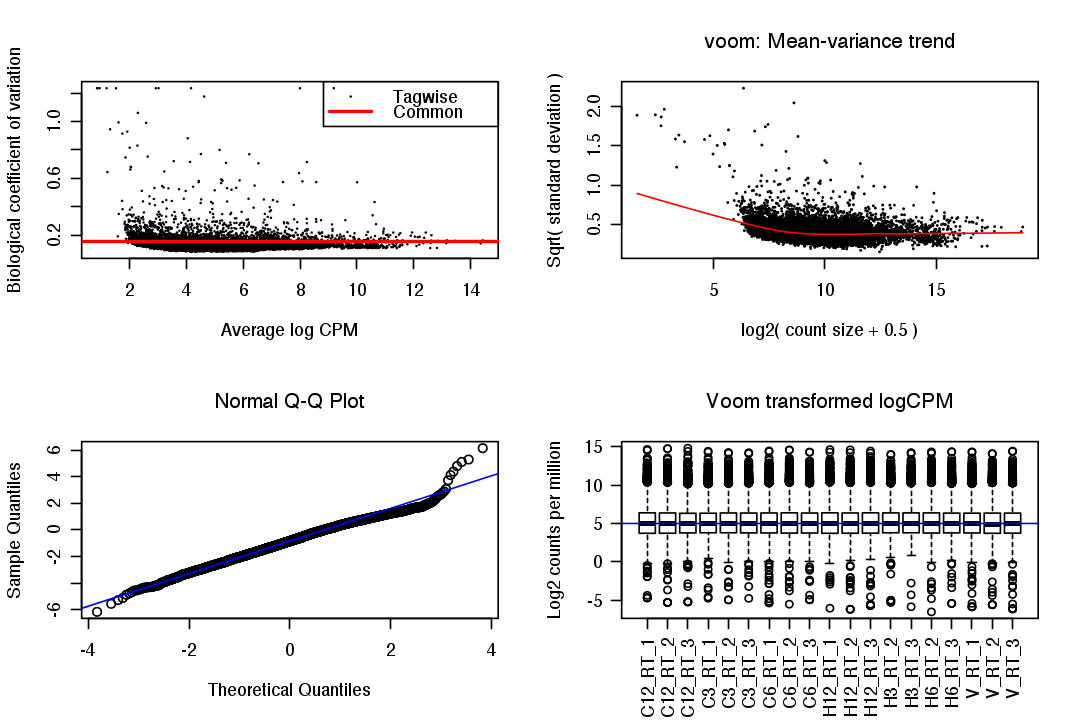

In [172]:
options(repr.plot.width = 9, repr.plot.height = 6)
par(mfrow=c(2,2))
# Biological coefficient of variation
plotBCV(dgeList.pm.1)
# mean-variance trend
pm.1.voom = voom(dgeList.pm.1, design.pm.1, plot=TRUE)
# QQ-plot
g.pm.1 <- gof(dgeList.pm.1_fit)
z.pm.1 <- zscoreGamma(g.pm.1$gof.statistics,shape=g.pm.1$df/2,scale=2)
qqnorm(z.pm.1); qqline(z.pm.1, col = 4,lwd=1,lty=1)
# log2 transformed and normalize boxplot of counts across samples
boxplot(pm.1.voom$E, xlab="", ylab="Log2 counts per million",las=2,main="Voom transformed logCPM")
abline(h=median(pm.1.voom$E),col="blue")

Looks good. Now let's look at sample groupings using a multidimensional scaling plot (try 'method = "bcv"' for a different type of grouping):

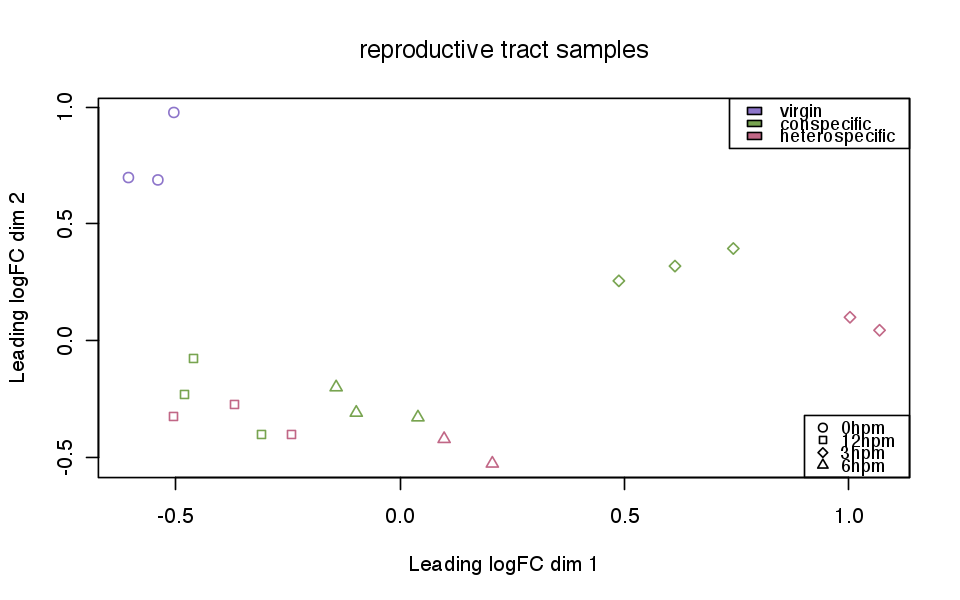

In [173]:
## colour samples by tissue-type
col.Status <- c("#8d75ca","#78a450","#c16786")[sampleInfo.pm$Status]
chr.time <- c(21:24)[sampleInfo.pm$time]

options(repr.plot.width = 8, repr.plot.height = 5)
plotMDS(dgeList.pm.1, col=col.Status, pch= chr.time, cex = 1)
legend("topright",legend=levels(sampleInfo.pm$Status), fill = c("#8d75ca","#78a450","#c16786"), cex = 0.85)
legend("bottomright",legend=levels(sampleInfo.pm$time), pch = c(21:24), cex = 0.85)
# Add a title
title("reproductive tract samples")



Can also look at int interactively with Glimma:

In [174]:
glMDSPlot(dgeList.pm.1, groups = sampleInfo.pm, labels = sampleInfo.pm$Replicate)

Replicates seem to largely group together in the first component, but two samples (H3_RT_1 and H6_RT_1) deviate from their sisters a bit. We'll consider removing those from the analysis later. For now, let's look at samples correlation:

for plotting:: min.raw: 0.951743949379817 max.raw: 1


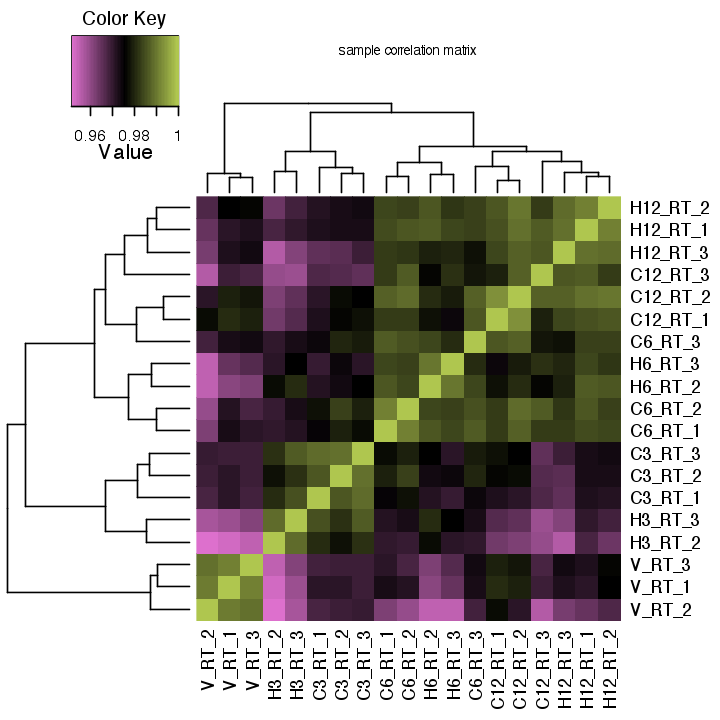

In [175]:
## Plot sample correlation
data = log2(countsMatrix.pm.filt+1)
data = as.matrix(data)
sample_cor = cor(data, method='pearson', use='pairwise.complete.obs')
sample_dist = as.dist(1-sample_cor)
hc_samples = hclust(sample_dist, method='complete')

options(repr.plot.width = 6, repr.plot.height = 6)
heatmap.3(sample_cor, dendrogram='both', Rowv=as.dendrogram(hc_samples), Colv=as.dendrogram(hc_samples), col = colorpanel(75, '#dd70cd','black','#afc64f'), scale='none', symm=TRUE, key=TRUE,density.info='none', trace='none', symkey=FALSE, symbreaks=F, cexCol=1, cexRow=1, cex.main=0.75, main=paste("sample correlation matrix"))

The correlations are mostly good. The three samples that aren't grouping where they should are:
* C6_RT_3
* H3_RT_1
* H6_RT_1


A final QC step is to look at MA plots within each sample:

Warning message:
"Removed 21 rows containing missing values (position_stack)."Warning message:
"Removed 4 rows containing missing values (geom_point)."

Warning message:
"Removed 22 rows containing missing values (position_stack)."Warning message:
"Removed 4 rows containing missing values (geom_point)."

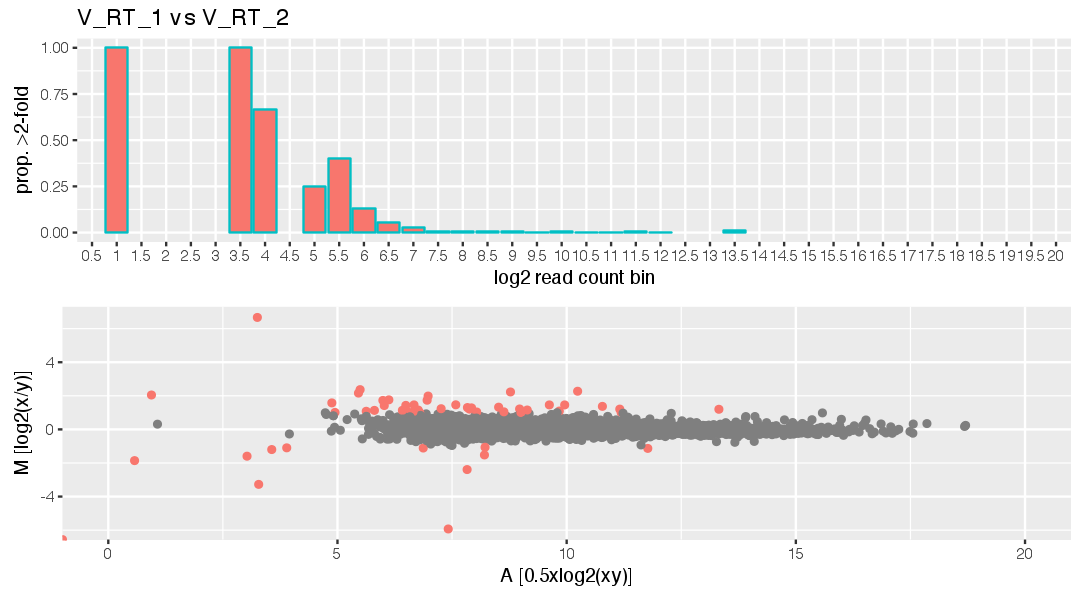

Warning message:
"Removed 20 rows containing missing values (position_stack)."Warning message:
"Removed 4 rows containing missing values (geom_point)."

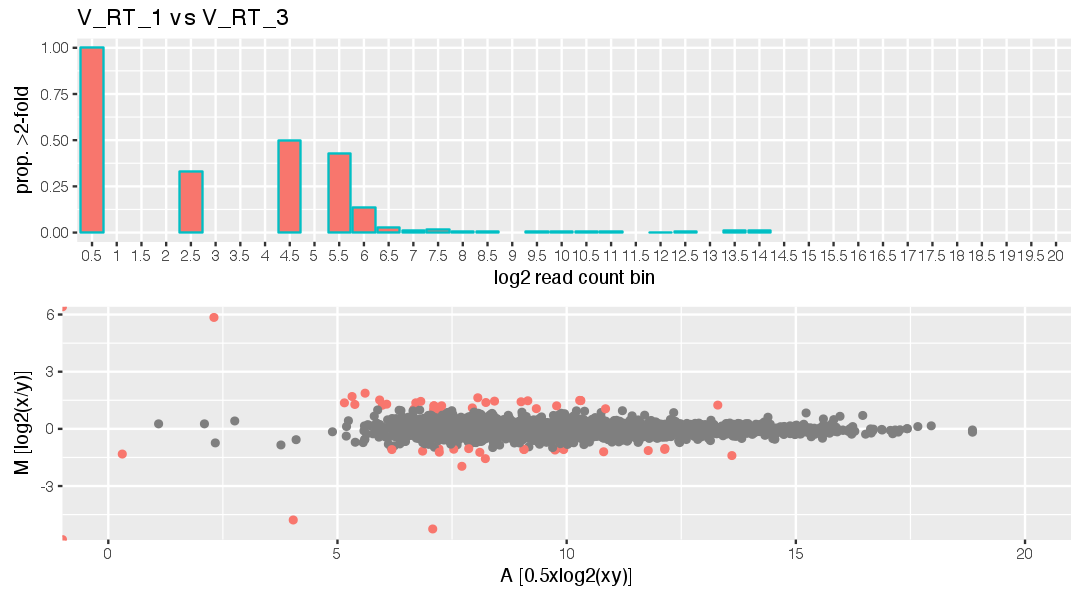

Warning message:
"Removed 21 rows containing missing values (position_stack)."

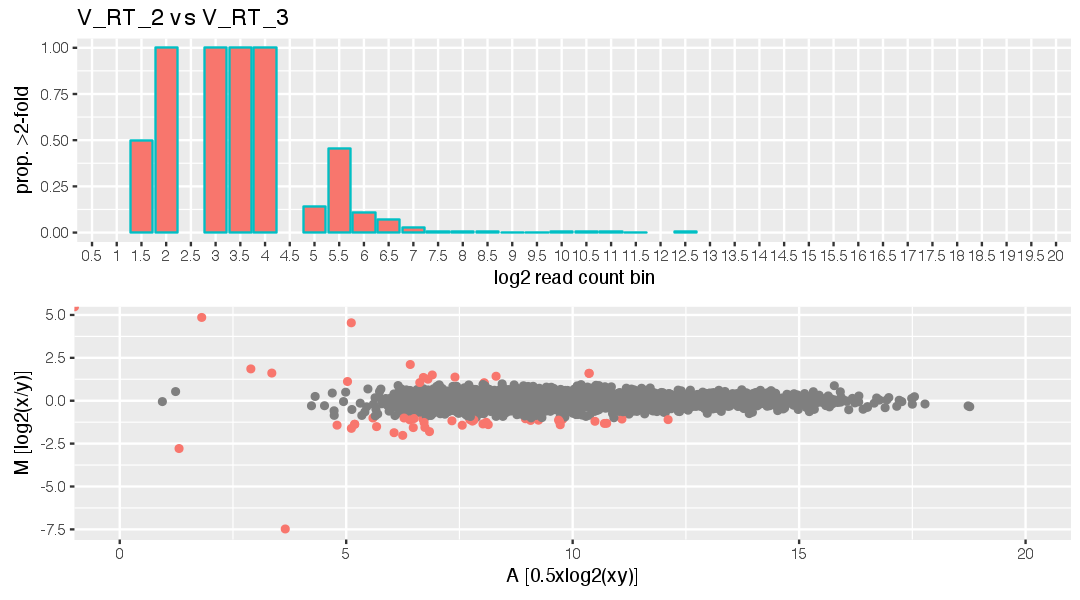

Warning message:
"Removed 23 rows containing missing values (position_stack)."

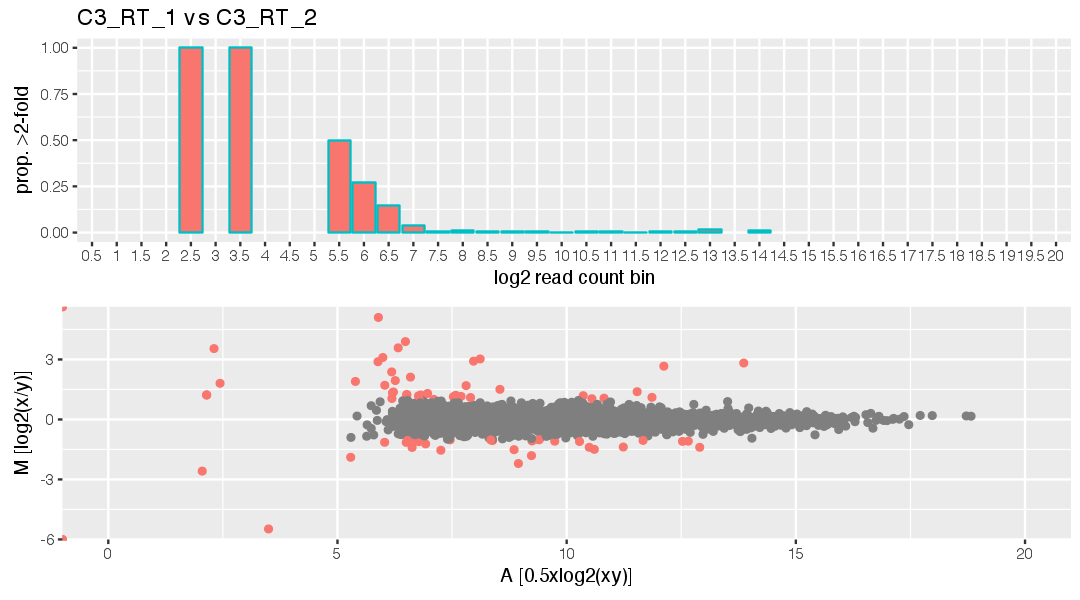

Warning message:
"Removed 19 rows containing missing values (position_stack)."

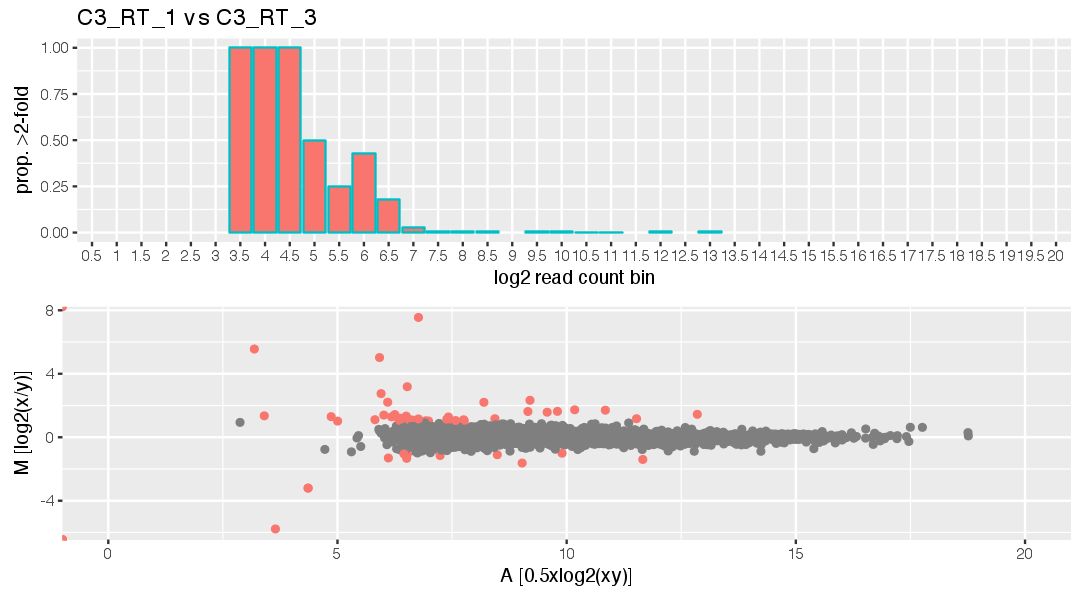

Warning message:
"Removed 22 rows containing missing values (position_stack)."Warning message:
"Removed 1 rows containing missing values (geom_point)."

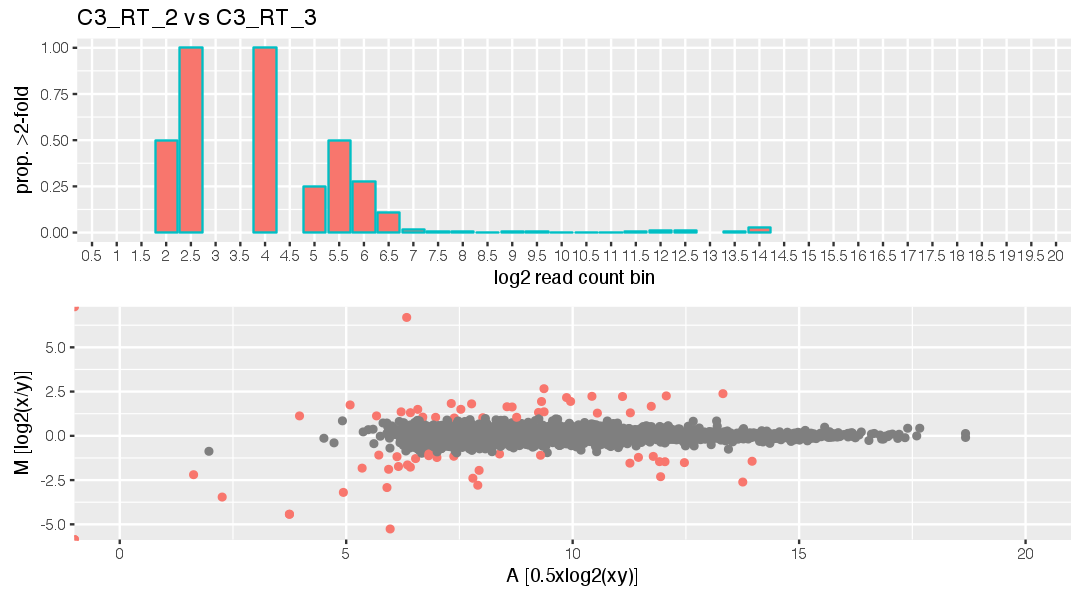

Warning message:
"Removed 21 rows containing missing values (position_stack)."Warning message:
"Removed 2 rows containing missing values (geom_point)."

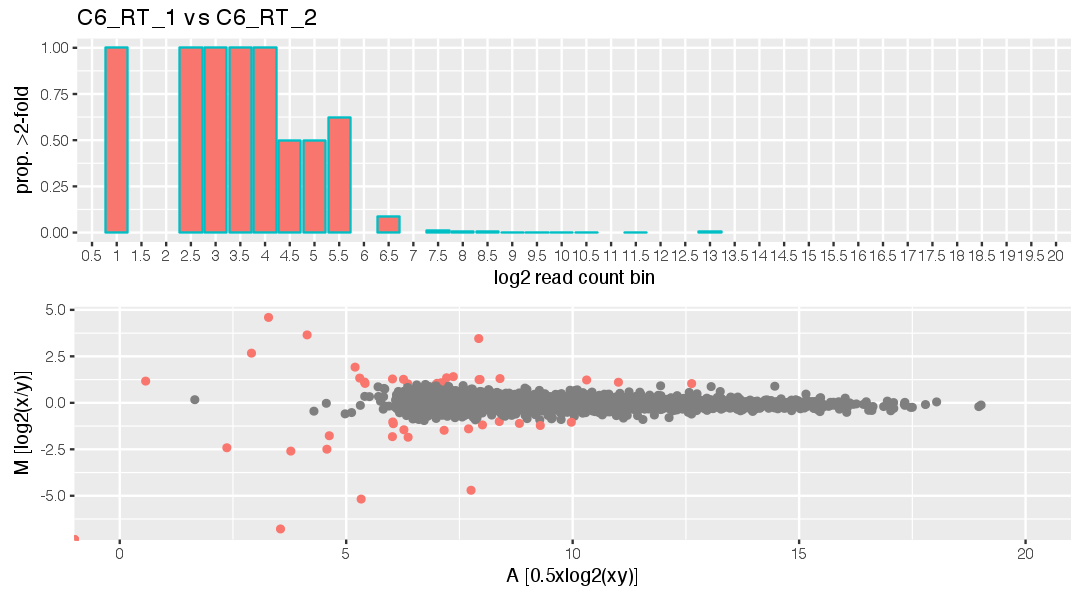

Warning message:
"Removed 18 rows containing missing values (position_stack)."

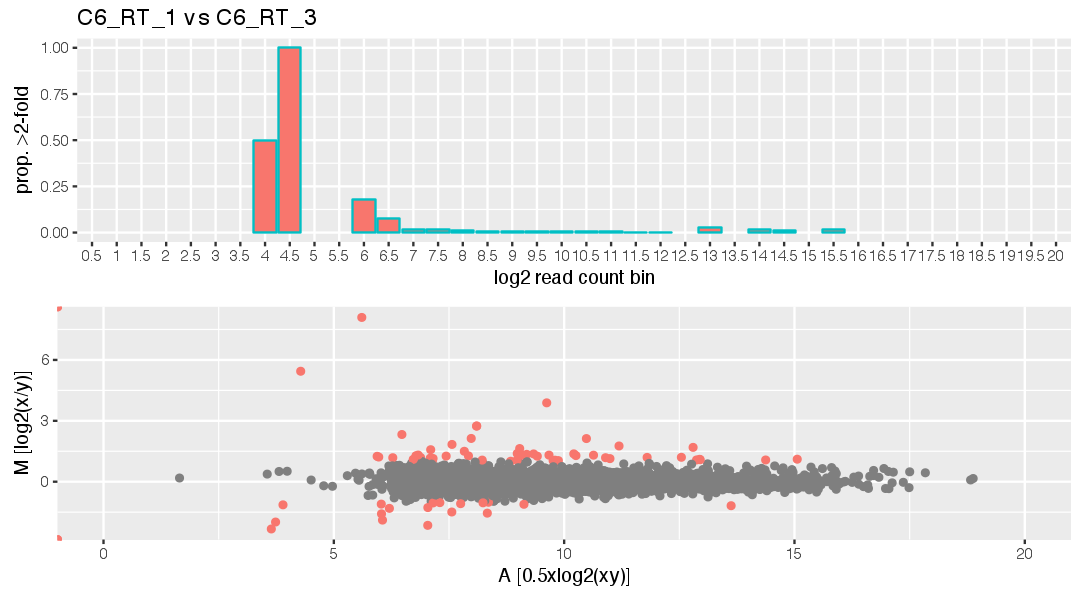

Warning message:
"Removed 25 rows containing missing values (position_stack)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

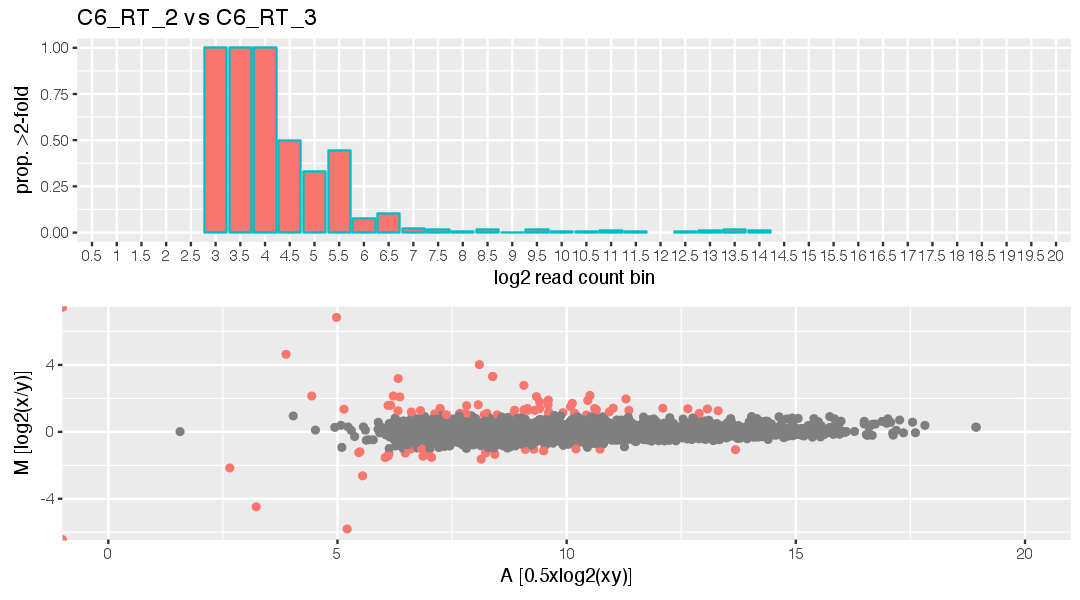

Warning message:
"Removed 19 rows containing missing values (position_stack)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

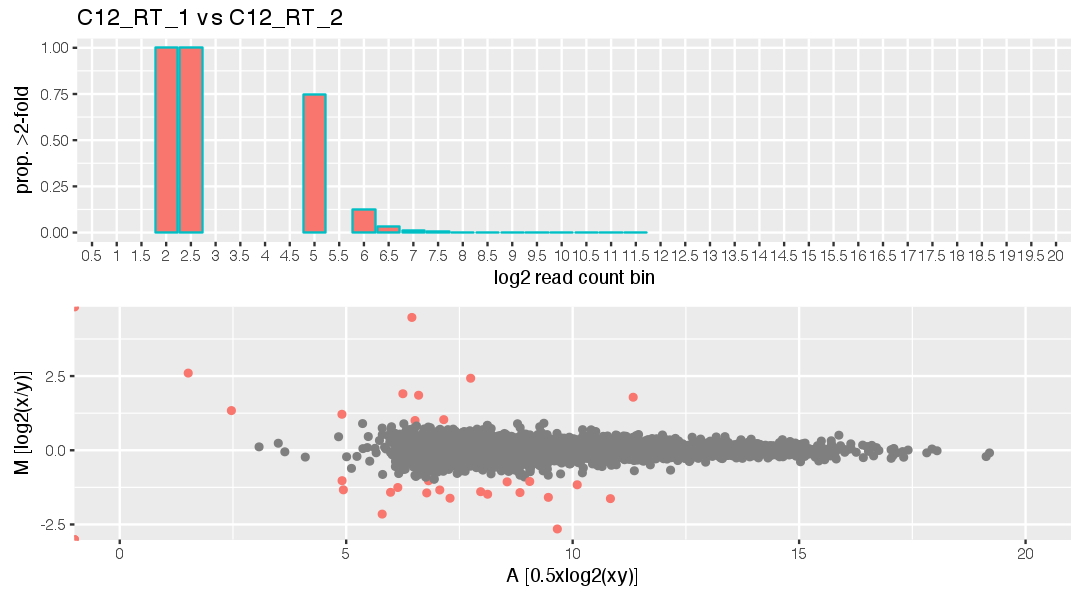

Warning message:
"Removed 22 rows containing missing values (position_stack)."Warning message:
"Removed 3 rows containing missing values (geom_point)."

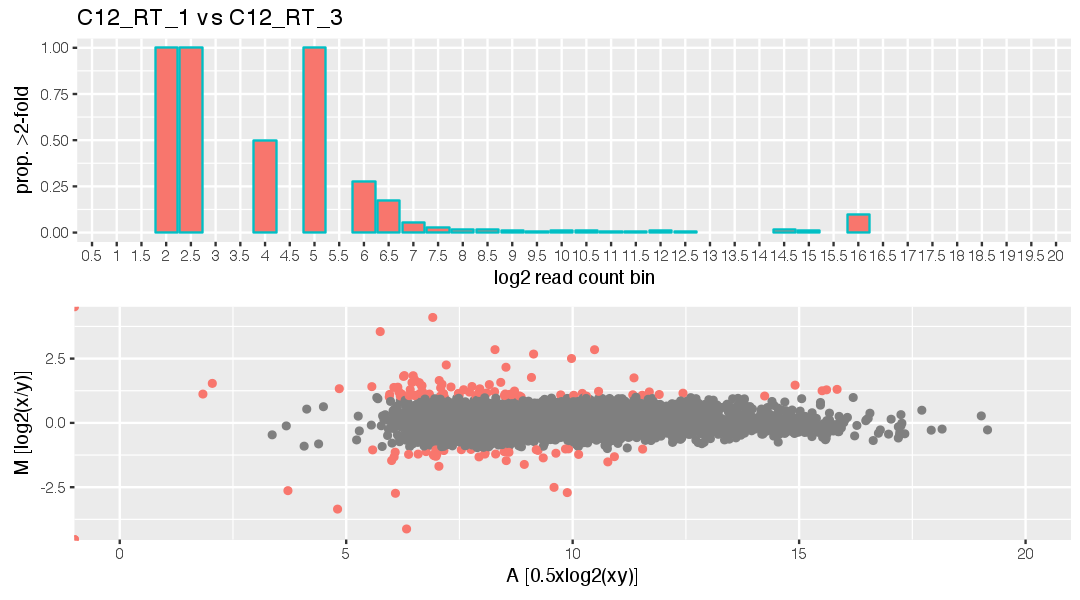

ERROR: Error in eval(expr, envir, enclos): object 'H3_RT_1' not found


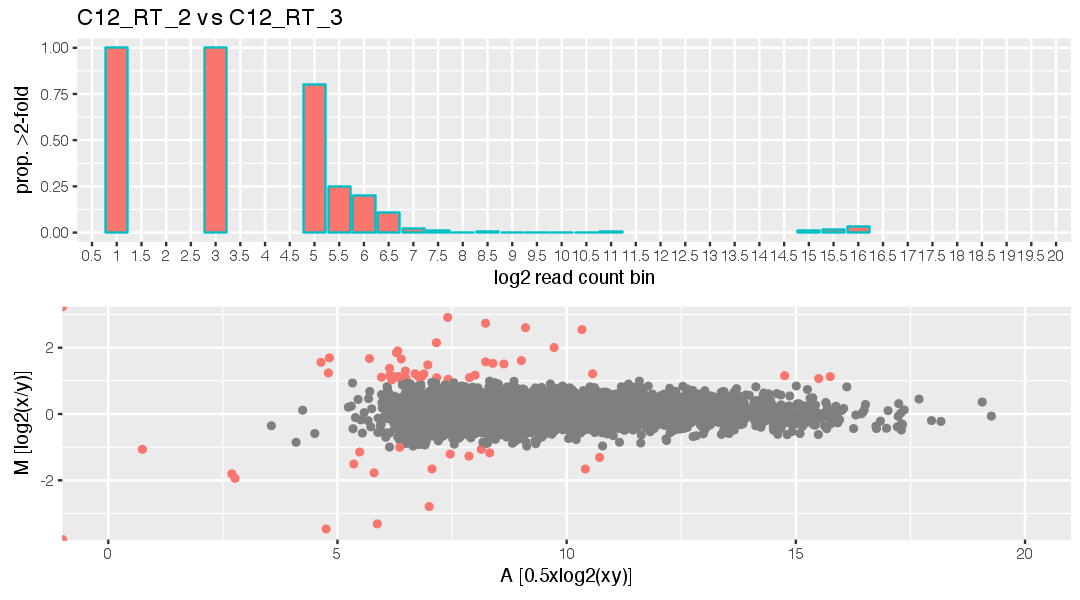

In [176]:
# normalize counts by the DESeq method (this is only used for these plots:
meta.pm <- data.frame(row.names=colnames(countsMatrix.pm.filt), condition=sampleInfo.pm$Status)
countData.pm<-round(countsMatrix.pm.filt)
countData.pm_normByDESeq = newCountDataSet(countData.pm, meta.pm)
countData.pm_normByDESeq = estimateSizeFactors(countData.pm_normByDESeq)
countData.pm_normByDESeq = data.frame(counts(countData.pm_normByDESeq, normalized=T))

options(repr.plot.width = 9, repr.plot.height = 5)
MA_BPlot(countData.pm_normByDESeq, "V_RT_1", "V_RT_2")
MA_BPlot(countData.pm_normByDESeq, "V_RT_1", "V_RT_3")
MA_BPlot(countData.pm_normByDESeq, "V_RT_2", "V_RT_3")
MA_BPlot(countData.pm_normByDESeq, "C3_RT_1", "C3_RT_2")
MA_BPlot(countData.pm_normByDESeq, "C3_RT_1", "C3_RT_3")
MA_BPlot(countData.pm_normByDESeq, "C3_RT_2", "C3_RT_3")
MA_BPlot(countData.pm_normByDESeq, "C6_RT_1", "C6_RT_2")
MA_BPlot(countData.pm_normByDESeq, "C6_RT_1", "C6_RT_3")
MA_BPlot(countData.pm_normByDESeq, "C6_RT_2", "C6_RT_3")
MA_BPlot(countData.pm_normByDESeq, "C12_RT_1", "C12_RT_2")
MA_BPlot(countData.pm_normByDESeq, "C12_RT_1", "C12_RT_3")
MA_BPlot(countData.pm_normByDESeq, "C12_RT_2", "C12_RT_3")
MA_BPlot(countData.pm_normByDESeq, "H3_RT_1", "H3_RT_2")
MA_BPlot(countData.pm_normByDESeq, "H3_RT_1", "H3_RT_3")
MA_BPlot(countData.pm_normByDESeq, "H3_RT_2", "H3_RT_3")
MA_BPlot(countData.pm_normByDESeq, "H6_RT_1", "H6_RT_2")
MA_BPlot(countData.pm_normByDESeq, "H6_RT_1", "H6_RT_3")
MA_BPlot(countData.pm_normByDESeq, "H6_RT_2", "H6_RT_3")
MA_BPlot(countData.pm_normByDESeq, "H12_RT_1", "H12_RT_2")
MA_BPlot(countData.pm_normByDESeq, "H12_RT_1", "H12_RT_3")
MA_BPlot(countData.pm_normByDESeq, "H12_RT_2", "H12_RT_3")

Now we can identify differentially expressed genes between postmating and virgin RT samples. First we'll compare conspecific to vrigin (coef=2), and use the log-fold cutoff of 1 (2-fold).

In [177]:
lrt_con.v.vir <- glmTreat(dgeList.pm.1_fit, coef =2, lfc =1)

#extract gene list of DE genes
DE.genes_con.v.virg <- subset(topTags(lrt_con.v.vir)$table, FDR < 0.05)$GeneID
DE.genes_con.v.virg

[1] "FBgn0207142" "FBgn0201082" "FBgn0206349" "FBgn0206457" "FBgn0208092"
 [6] "FBgn0202764" "FBgn0199412" "FBgn0211009" "FBgn0207331" "FBgn0198037"

... Now compare virgin to conspecific:

In [178]:
lrt_het.v.vir <- glmTreat(dgeList.pm.1_fit, coef =3, lfc =1)

#extract gene list of DE genes
DE.genes_con.v.virg <- subset(topTags(lrt_het.v.vir)$table, FDR < 0.05)$GeneID
DE.genes_con.v.virg

[1] "FBgn0207142" "FBgn0201082" "FBgn0206457" "FBgn0207331" "FBgn0206349"
 [6] "FBgn0208092" "FBgn0202764" "FBgn0283370" "FBgn0199412" "FBgn0211009"

Ten genes are DE between postmating RT samples and virgin RT samples. We can plot them to see their expression pattern in the RT:

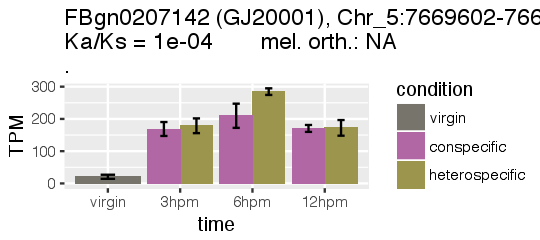

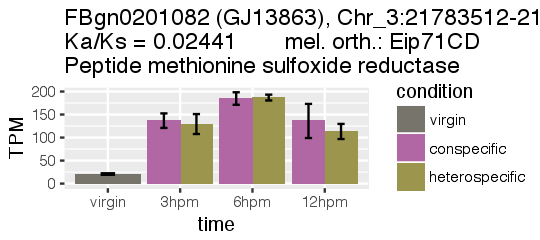

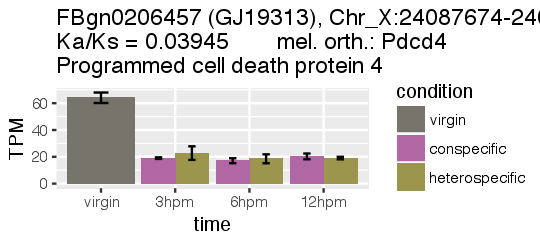

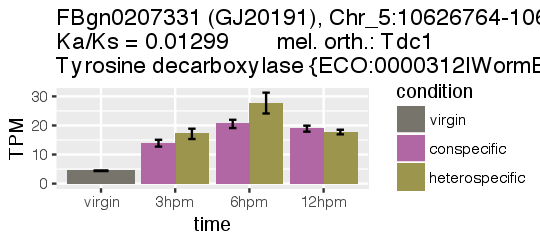

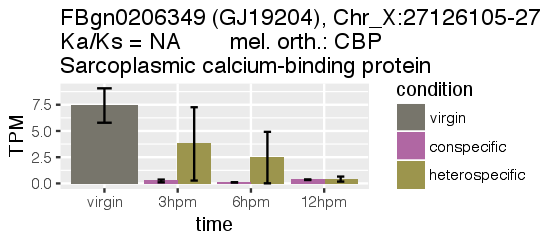

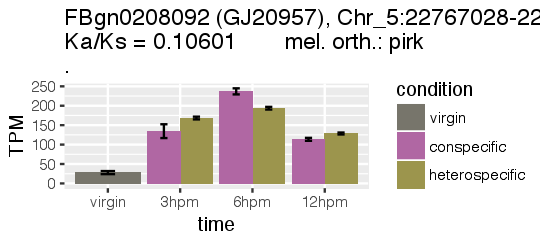

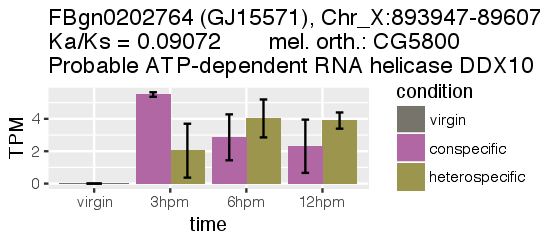

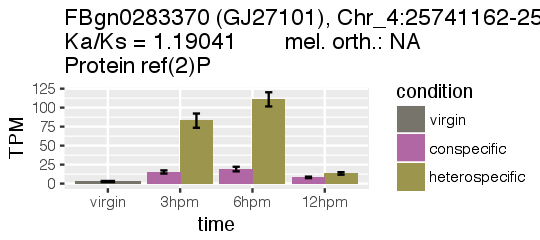

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]


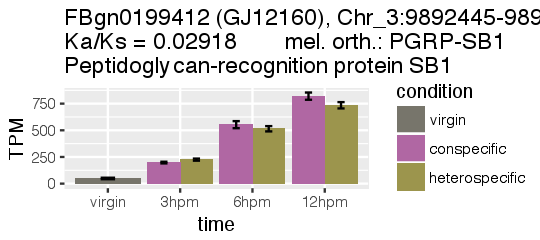

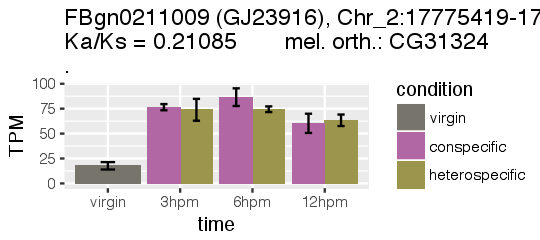

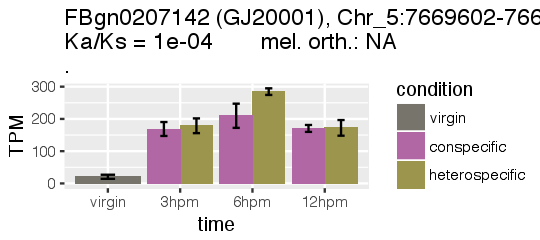

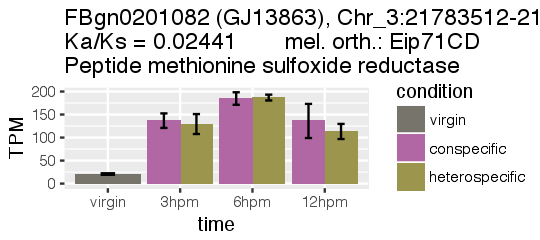

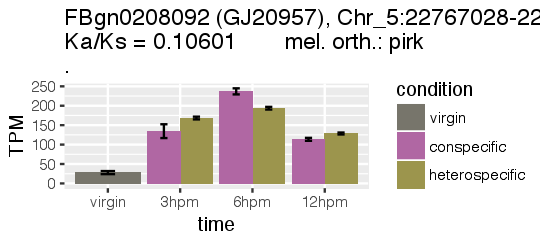

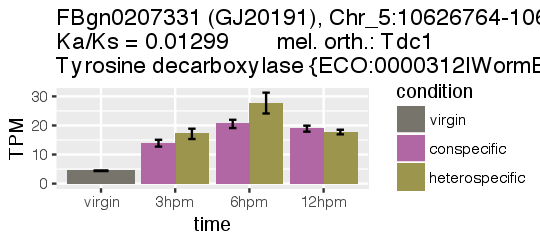

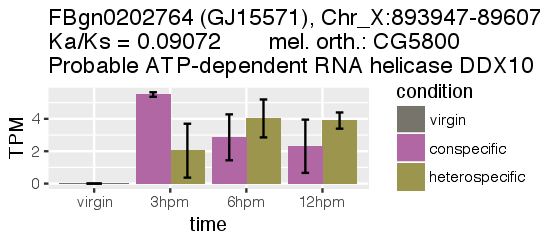

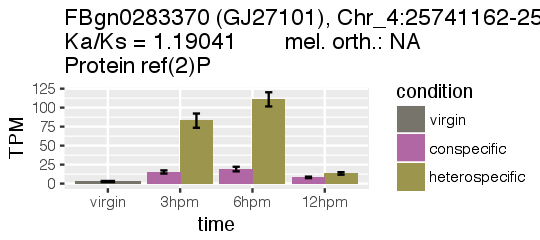

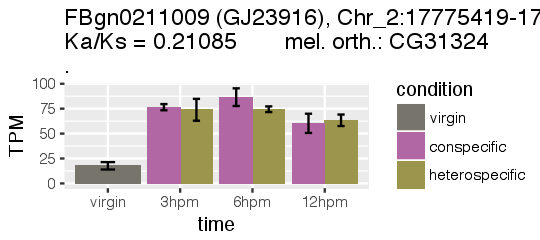

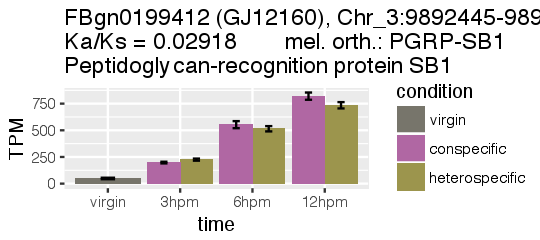

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]

[[8]]

[[9]]

[[10]]


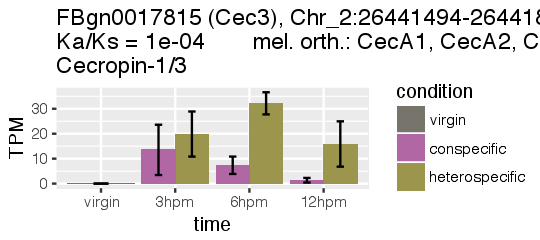

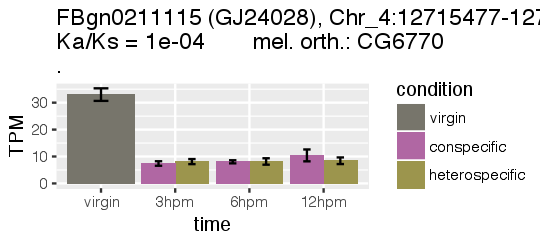

In [179]:
options(repr.plot.width = 4.5, repr.plot.height = 2)
lapply(DE.genes_con.v.virg, plotGenePM_RT, object = TPMse)
lapply(DE.genes_het.v.virg, plotGenePM_RT, object = TPMse)


#### 2. Comparing heterospecific to conspecific RT samples

We can use the above design to test for overall DE between conspecific and heterospecific postmating samples:

In [180]:
lrt_con.v.het <- glmTreat(dgeList.pm.1_fit, contrast = c(0,-1,1), lfc =1)

#extract gene list of DE genes
DE.genes_con.v.het <- subset(topTags(lrt_con.v.het)$table, FDR < 0.05)$GeneID
DE.genes_con.v.het

[1] "FBgn0209590" "FBgn0208031" "FBgn0207711"

Let's make barplots of those genes:

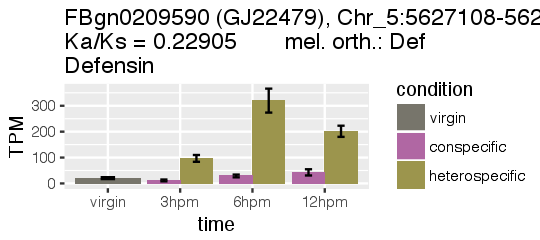

[[1]]

[[2]]

[[3]]


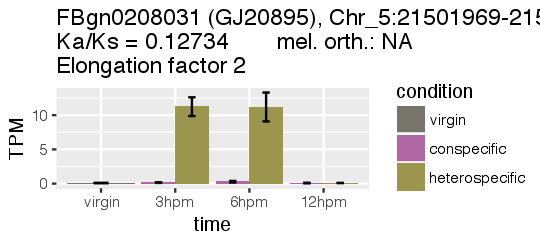

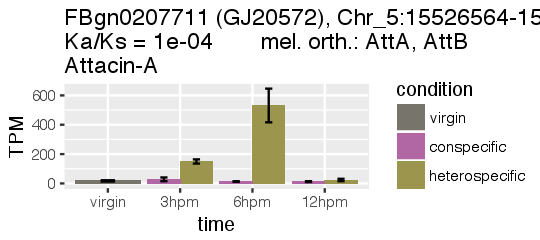

In [181]:
options(repr.plot.width = 4.5, repr.plot.height = 2)
lapply(DE.genes_con.v.het, plotGenePM_RT, object = TPMse)

Using this approach, which looks for significant differences by averaging across all three time points, only three genes show up as significant between conspecific and heterospecific samples. To detect more DE genes, we'll need to compare samples within each postmating time point.

#### 3. Comparing each postmating time point to the virgin RT sample

Here we can set up new grouping and comparison matrix with all the postmating time-point samples by combining the "Status" and "time" factors:

In [186]:
## Will need to relevel the Status grouping to make virgin control
#sampleInfo.pm$Status <- relevel(sampleInfo.pm$Status, ref = "virgin")
Status.time <- factor(paste(sampleInfo.pm$Status, sampleInfo.pm$time, sep="."))
sampleInfo.pm.3 <- cbind(sampleInfo.pm, Group=Status.time)

groups.pm.3 <- factor(sampleInfo.pm.3$Group)
design.pm.3 <- model.matrix(~groups.pm.3)
#colnames(design.pm.1) <- levels(groups.pm.1)
#rownames(design.pm.1) <- sampleInfo.pm$Replicate
#head(design.pm.1)
groups.pm.3
design.pm.3

[1] conspecific.12hpm    conspecific.12hpm    conspecific.12hpm   
 [4] conspecific.3hpm     conspecific.3hpm     conspecific.3hpm    
 [7] conspecific.6hpm     conspecific.6hpm     conspecific.6hpm    
[10] heterospecific.12hpm heterospecific.12hpm heterospecific.12hpm
[13] heterospecific.3hpm  heterospecific.3hpm  heterospecific.6hpm 
[16] heterospecific.6hpm  virgin.0hpm          virgin.0hpm         
[19] virgin.0hpm         
7 Levels: conspecific.12hpm conspecific.3hpm ... virgin.0hpm

,(Intercept),groups.pm.3conspecific.3hpm,groups.pm.3conspecific.6hpm,groups.pm.3heterospecific.12hpm,groups.pm.3heterospecific.3hpm,groups.pm.3heterospecific.6hpm,groups.pm.3virgin.0hpm
1,1,0,0,0,0,0,0
2,1,0,0,0,0,0,0
3,1,0,0,0,0,0,0
4,1,1,0,0,0,0,0
5,1,1,0,0,0,0,0
6,1,1,0,0,0,0,0
7,1,0,1,0,0,0,0
8,1,0,1,0,0,0,0
9,1,0,1,0,0,0,0
10,1,0,0,1,0,0,0


Define contrasts to be tested

In [47]:
con_virgin_contrasts <- makeContrasts(C3.vs.V=C3_RT-V_RT, C6.vs.V=C6_RT-V_RT, C12.vs.V=C12_RT-V_RT, levels = RT.design)
het_virgin_contrasts <- makeContrasts(H3.vs.V=H3_RT-V_RT, H6.vs.V=H6_RT-V_RT, H12.vs.V=H12_RT-V_RT, levels = RT.design)

Identify DE genes between virgin and all postmating samples

In [48]:
RT_con.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts)
RT_con.vs.virgin.tTags <- topTags(RT_con.vs.virgin, n = NULL)
RT_con.vs.virgin.tTags.table <- RT_con.vs.virgin.tTags$table
RT_con.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_con.vs.virgin.tTags.table)

RT_het.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts)
RT_het.vs.virgin.tTags <- topTags(RT_het.vs.virgin, n = NULL)
RT_het.vs.virgin.tTags.table <- RT_het.vs.virgin.tTags$table
RT_het.vs.virgin.tTags.table$FBgn_ID <- rownames(RT_het.vs.virgin.tTags.table)

In [49]:
colnames(RT_con.vs.virgin.tTags.table) = c("3hpm", "6hpm", "12hpm", "logCPM", "LR", "pvalue", "FDR", "FBgn_ID")
colnames(RT_het.vs.virgin.tTags.table) = c("3hpm", "6hpm", "12hpm", "logCPM", "LR", "pvalue", "FDR", "FBgn_ID")

head(RT_con.vs.virgin.tTags.table)
head(RT_het.vs.virgin.tTags.table)

,3hpm,6hpm,12hpm,logCPM,LR,pvalue,FDR,FBgn_ID
FBgn0198861,2.9935293,1.204777,0.3051668,5.241462,873.2722,5.550898e-189,3.710220e-185,FBgn0198861
FBgn0199412,2.0701762,3.504898,4.0818578,7.766424,659.5361,1.246726e-142,4.166558e-139,FBgn0199412
FBgn0198037,-1.8604222,-2.203550,-2.8935859,3.309744,337.8169,6.479754e-73,1.443689e-69,FBgn0198037
FBgn0208092,2.3176135,3.063180,2.0314281,6.720275,294.3007,1.703014e-63,2.845737e-60,FBgn0208092
FBgn0209375,0.7611869,2.202677,2.0905668,5.235392,259.1301,6.933999e-56,9.269370e-53,FBgn0209375
FBgn0200611,1.3625801,2.026408,1.7716102,7.202215,249.1764,9.861973e-54,1.082821e-50,FBgn0200611


,3hpm,6hpm,12hpm,logCPM,LR,pvalue,FDR,FBgn_ID
FBgn0208031,7.012423,6.535943,-0.05205981,2.418138,1327.2971,1.757327e-287,1.174598e-283,FBgn0208031
FBgn0198861,2.775086,1.454250,0.38921066,5.241462,618.8314,8.334880e-134,2.785517e-130,FBgn0198861
FBgn0199412,2.325487,3.403601,3.92392518,7.766424,573.8805,4.629583e-124,1.031471e-120,FBgn0199412
FBgn0206847,3.346474,2.729407,0.61313307,2.935890,519.9622,2.251187e-112,3.761733e-109,FBgn0206847
FBgn0203480,1.638590,1.093669,0.03535923,5.121406,382.8619,1.140744e-82,1.524947e-79,FBgn0203480
FBgn0205175,2.641661,2.162041,0.85732450,4.989258,316.6537,2.472435e-68,2.754292e-65,FBgn0205175


In [50]:
PM.RT.con_vs_virgin.m <-melt(RT_con.vs.virgin.tTags.table, id.vars = c("pvalue", "FDR", "FBgn_ID", "LR", "logCPM"))
PM.RT.con_vs_virgin.m$cross = "Conspecific"
PM.RT.het_vs_virgin.m <-melt(RT_het.vs.virgin.tTags.table, id.vars = c("pvalue", "FDR", "FBgn_ID", "LR", "logCPM"))
PM.RT.het_vs_virgin.m$cross = "Heterospecific"

RT.PM_vs_virgin.m = rbind(PM.RT.con_vs_virgin.m, PM.RT.het_vs_virgin.m)
RT.PM_vs_virgin.m$sig = ifelse(RT.PM_vs_virgin.m$FDR < 0.00001, "YES", "NO")
head(RT.PM_vs_virgin.m)

pvalue,FDR,FBgn_ID,LR,logCPM,variable,value,cross,sig
5.550898e-189,3.710220e-185,FBgn0198861,873.2722,5.241462,3hpm,2.9935293,Conspecific,YES
1.246726e-142,4.166558e-139,FBgn0199412,659.5361,7.766424,3hpm,2.0701762,Conspecific,YES
6.479754e-73,1.443689e-69,FBgn0198037,337.8169,3.309744,3hpm,-1.8604222,Conspecific,YES
1.703014e-63,2.845737e-60,FBgn0208092,294.3007,6.720275,3hpm,2.3176135,Conspecific,YES
6.933999e-56,9.269370e-53,FBgn0209375,259.1301,5.235392,3hpm,0.7611869,Conspecific,YES
9.861973e-54,1.082821e-50,FBgn0200611,249.1764,7.202215,3hpm,1.3625801,Conspecific,YES


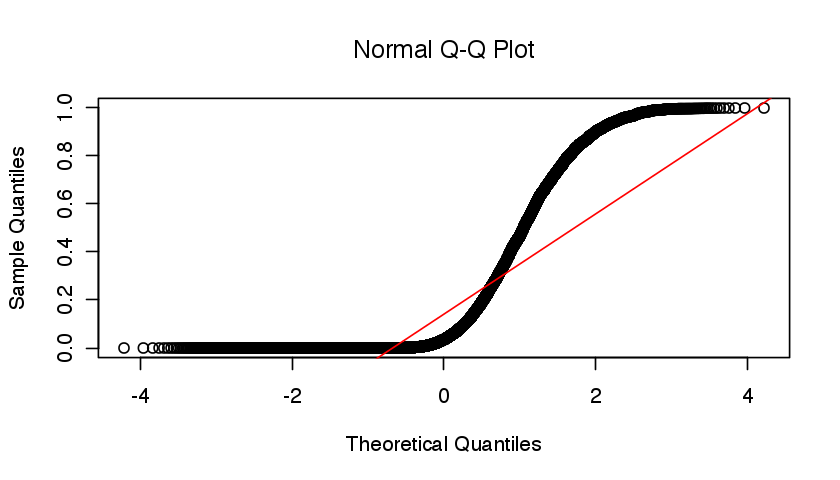

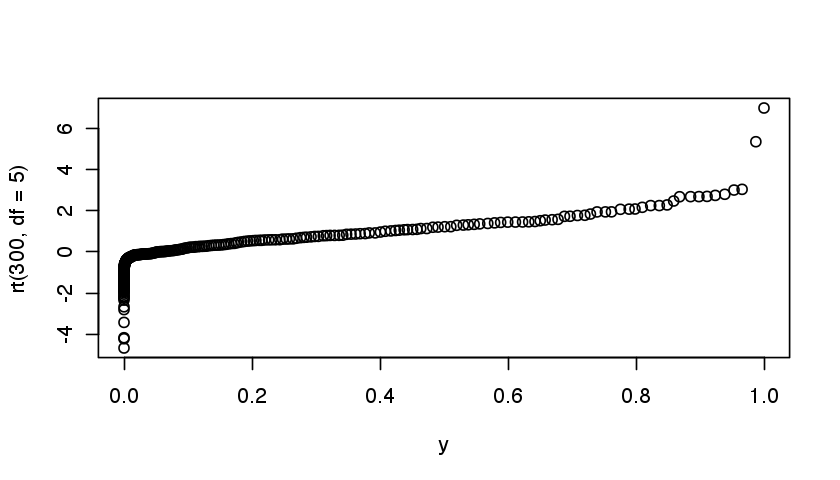

In [55]:
y <- RT.PM_vs_virgin.m$pvalue
qqnorm(y); qqline(y, col = 2)
qqplot(y, rt(300, df = 5))

In [52]:
ggplot(data, aes(sample = RT.PM_vs_virgin.m$pvalue)) + stat_qq(color="firebrick2", alpha=1) + geom_abline(intercept = mean(RT.PM_vs_virgin.m$pvalue), slope = sd(RT.PM_vs_virgin.m$pvalue))

ERROR: Error: ggplot2 doesn't know how to deal with data of class matrix


In [ ]:
options(repr.plot.width = 9, repr.plot.height = 4)
ggplot(RT.PM_vs_virgin.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_grid(cross~variable, scales = "free")

In [ ]:
length(unique(subset(RT.PM_vs_virgin.m, sig == "YES")$FBgn_ID))

### Pair-wise DE contrasts

Perform pair-wise DE analysis between each PM RT sample and the virgin RT sample

In [ ]:
# C3_RT vs V_RT
RT_con.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C3.vs.V"])
RT_con.3hrs.vs.virgin.tTags <- topTags(RT_con.3hrs.vs.virgin, n = NULL)
RT_con.3hrs.vs.virgin.tTags.table <- RT_con.3hrs.vs.virgin.tTags$table
RT_con.3hrs.vs.virgin.Up.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.3hrs.vs.virgin.Down.list <- rownames(subset(RT_con.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# C6_RT vs V_RT
RT_con.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C6.vs.V"])
RT_con.6hrs.vs.virgin.tTags <- topTags(RT_con.6hrs.vs.virgin, n = NULL)
RT_con.6hrs.vs.virgin.tTags.table <- RT_con.6hrs.vs.virgin.tTags$table
RT_con.6hrs.vs.virgin.Up.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.6hrs.vs.virgin.Down.list <- rownames(subset(RT_con.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# C12_RT vs V_RT
RT_con.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = con_virgin_contrasts[,"C12.vs.V"])
RT_con.12hrs.vs.virgin.tTags <- topTags(RT_con.12hrs.vs.virgin, n = NULL)
RT_con.12hrs.vs.virgin.tTags.table <- RT_con.12hrs.vs.virgin.tTags$table
RT_con.12hrs.vs.virgin.Up.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_con.12hrs.vs.virgin.Down.list <- rownames(subset(RT_con.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
# H3_RT vs V_RT
RT_het.3hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H3.vs.V"])
RT_het.3hrs.vs.virgin.tTags <- topTags(RT_het.3hrs.vs.virgin, n = NULL)
RT_het.3hrs.vs.virgin.tTags.table <- RT_het.3hrs.vs.virgin.tTags$table
RT_het.3hrs.vs.virgin.Up.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.3hrs.vs.virgin.Down.list <- rownames(subset(RT_het.3hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# H6_RT vs V_RT
RT_het.6hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H6.vs.V"])
RT_het.6hrs.vs.virgin.tTags <- topTags(RT_het.6hrs.vs.virgin, n = NULL)
RT_het.6hrs.vs.virgin.tTags.table <- RT_het.6hrs.vs.virgin.tTags$table
RT_het.6hrs.vs.virgin.Up.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.6hrs.vs.virgin.Down.list <- rownames(subset(RT_het.6hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))
# H12_RT vs V_RT
RT_het.12hrs.vs.virgin <- glmLRT(DnovPM_RT_fit, contrast = het_virgin_contrasts[,"H12.vs.V"])
RT_het.12hrs.vs.virgin.tTags <- topTags(RT_het.12hrs.vs.virgin, n = NULL)
RT_het.12hrs.vs.virgin.tTags.table <- RT_het.12hrs.vs.virgin.tTags$table
RT_het.12hrs.vs.virgin.Up.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC > 1 & FDR < 0.001))
RT_het.12hrs.vs.virgin.Down.list <- rownames(subset(RT_het.12hrs.vs.virgin.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
RT_UP_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Up.list, Heterospecific = RT_het.3hrs.vs.virgin.Up.list)
RT_UP_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Up.list, Heterospecific = RT_het.6hrs.vs.virgin.Up.list)
RT_UP_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Up.list, Heterospecific = RT_het.12hrs.vs.virgin.Up.list)
RT_Down_3hrs_candidates <- list(Conspecific = RT_con.3hrs.vs.virgin.Down.list, Heterospecific = RT_het.3hrs.vs.virgin.Down.list)
RT_Down_6hrs_candidates <- list(Conspecific = RT_con.6hrs.vs.virgin.Down.list, Heterospecific = RT_het.6hrs.vs.virgin.Down.list)
RT_Down_12hrs_candidates <- list(Conspecific = RT_con.12hrs.vs.virgin.Down.list, Heterospecific = RT_het.12hrs.vs.virgin.Down.list)

In [ ]:
# Rearrange into lists of lists, and partition by species
RT_UP_3hrs_combs <- unlist(lapply(1:length(RT_UP_3hrs_candidates), function(j) combn(names(RT_UP_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_6hrs_combs <- unlist(lapply(1:length(RT_UP_6hrs_candidates), function(j) combn(names(RT_UP_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_UP_12hrs_combs <- unlist(lapply(1:length(RT_UP_12hrs_candidates), function(j) combn(names(RT_UP_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_3hrs_combs <- unlist(lapply(1:length(RT_Down_3hrs_candidates), function(j) combn(names(RT_Down_3hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_6hrs_combs <- unlist(lapply(1:length(RT_Down_6hrs_candidates), function(j) combn(names(RT_Down_6hrs_candidates), j, simplify = FALSE)), recursive = FALSE)
RT_Down_12hrs_combs <- unlist(lapply(1:length(RT_Down_12hrs_candidates), function(j) combn(names(RT_Down_12hrs_candidates), j, simplify = FALSE)), recursive = FALSE)

names(RT_UP_3hrs_combs) <- sapply(RT_UP_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_6hrs_combs) <- sapply(RT_UP_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_UP_12hrs_combs) <- sapply(RT_UP_12hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_3hrs_combs) <- sapply(RT_Down_3hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_6hrs_combs) <- sapply(RT_Down_6hrs_combs, function(i) paste0(i, collapse = ","))
names(RT_Down_12hrs_combs) <- sapply(RT_Down_12hrs_combs, function(i) paste0(i, collapse = ","))

RT_UP_3hrs_elements <- lapply(RT_UP_3hrs_combs, function(i) Setdiff(RT_UP_3hrs_candidates[i], RT_UP_3hrs_candidates[setdiff(names(RT_UP_3hrs_candidates), i)]))
RT_UP_6hrs_elements <- lapply(RT_UP_6hrs_combs, function(i) Setdiff(RT_UP_6hrs_candidates[i], RT_UP_6hrs_candidates[setdiff(names(RT_UP_6hrs_candidates), i)]))
RT_UP_12hrs_elements <- lapply(RT_UP_12hrs_combs, function(i) Setdiff(RT_UP_12hrs_candidates[i], RT_UP_12hrs_candidates[setdiff(names(RT_UP_12hrs_candidates), i)]))
RT_Down_3hrs_elements <- lapply(RT_Down_3hrs_combs, function(i) Setdiff(RT_Down_3hrs_candidates[i], RT_Down_3hrs_candidates[setdiff(names(RT_Down_3hrs_candidates), i)]))
RT_Down_6hrs_elements <- lapply(RT_Down_6hrs_combs, function(i) Setdiff(RT_Down_6hrs_candidates[i], RT_Down_6hrs_candidates[setdiff(names(RT_Down_6hrs_candidates), i)]))
RT_Down_12hrs_elements <- lapply(RT_Down_12hrs_combs, function(i) Setdiff(RT_Down_12hrs_candidates[i], RT_Down_12hrs_candidates[setdiff(names(RT_Down_12hrs_candidates), i)]))

In [ ]:
### Draw a VennDiagram of each element
RT_UP_3hrs_Vdiag<-venn.diagram(RT_UP_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_UP_6hrs_Vdiag<-venn.diagram(RT_UP_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_UP_12hrs_Vdiag<-venn.diagram(RT_UP_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 4, repr.plot.height = 3)
grid.arrange(gTree(children=RT_UP_3hrs_Vdiag), gTree(children=RT_UP_6hrs_Vdiag), gTree(children=RT_UP_12hrs_Vdiag))

In [ ]:
RT_Down_3hrs_Vdiag<-venn.diagram(RT_Down_3hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "3hpm")
RT_Down_6hrs_Vdiag<-venn.diagram(RT_Down_6hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "6hpm")
RT_Down_12hrs_Vdiag<-venn.diagram(RT_Down_12hrs_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 2, cat.cex = 0, resolution = 1000, main = "12hpm")

options(repr.plot.width = 4, repr.plot.height = 3)
grid.arrange(gTree(children=RT_Down_3hrs_Vdiag), gTree(children=RT_Down_6hrs_Vdiag), gTree(children=RT_Down_12hrs_Vdiag))

Test Difference between conspecific and heterospecific PM samples:

In [ ]:
condition.group = subset(m.DnovPM.TPM.tmp, FBgn_ID == "FBgn0202928" & tissue == "RT")
condition.group$replicates = colnames(DnovPM_CountsMatrix_RT.min400)
rownames(condition.group) <- condition.group$replicates
condition.group = subset(condition.group, select = c(sample, condition, time))

condition.design <- model.matrix(~0+condition, data = condition.group)
colnames(condition.design) <- unique(condition.group$condition)

condition.contrasts <- makeContrasts(con.vs.het = conspecific-heterospecific,
                                     con.vs.vir = conspecific - virgin,
                                     het.vs.vir = heterospecific - virgin,
                                     levels = condition.design)

In [ ]:
lrt <- glmFit(DnovPM_DGElist_RT, condition.design)
con.vs.het.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"con.vs.het"])
con.vs.het.RT.all.tTags <- topTags(con.vs.het.RT.all.contrast, n = NULL)
con.vs.het.RT.all.tTags.table <- con.vs.het.RT.all.tTags$table
con.vs.het.RT.het.Up.list <- rownames(subset(con.vs.het.RT.all.tTags.table, logFC < -1 & FDR < 0.001))
con.vs.het.RT.con.Up.list <- rownames(subset(con.vs.het.RT.all.tTags.table, logFC > 1 & FDR < 0.001))

con.vs.vir.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"con.vs.vir"])
con.vs.vir.RT.all.tTags <- topTags(con.vs.vir.RT.all.contrast, n = NULL)
con.vs.vir.RT.all.tTags.table <- con.vs.vir.RT.all.tTags$table
con.vs.vir.RT.con.Up.list <- rownames(subset(con.vs.vir.RT.all.tTags.table, logFC > 1 & FDR < 0.001))
con.vs.vir.RT.con.Down.list <- rownames(subset(con.vs.vir.RT.all.tTags.table, logFC < -1 & FDR < 0.001))

het.vs.vir.RT.all.contrast <- glmLRT(lrt, contrast = condition.contrasts[,"het.vs.vir"])
het.vs.vir.RT.all.tTags <- topTags(het.vs.vir.RT.all.contrast, n = NULL)
het.vs.vir.RT.all.tTags.table <- het.vs.vir.RT.all.tTags$table
het.vs.vir.RT.het.Up.list <- rownames(subset(het.vs.vir.RT.all.tTags.table, logFC > 1 & FDR < 0.001))
het.vs.vir.RT.het.Down.list <- rownames(subset(het.vs.vir.RT.all.tTags.table, logFC < -1 & FDR < 0.001))

In [ ]:
PM.vs.vir_Up_candidates <- list(conspecific = con.vs.vir.RT.con.Up.list, heterospecific = het.vs.vir.RT.het.Up.list)
PM.vs.vir_Down_candidates <- list(conspecific = con.vs.vir.RT.con.Down.list, heterospecific = het.vs.vir.RT.het.Down.list)


PM.vs.vir_Up_candidates_Vdiag<-venn.diagram(PM.vs.vir_Up_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 4, cat.cex = 0, resolution = 1000, main = "Upregulated")
PM.vs.vir_Down_candidates_Vdiag<-venn.diagram(PM.vs.vir_Down_candidates, NULL, fill=c("#b067a3", "#9c954d"), alpha=c(0.75,0.75), cex = 1.5, cat.fontface= 4, cat.cex = 0, resolution = 1000, main = "Downregulated")
options(repr.plot.width = 4, repr.plot.height = 1)
grid.arrange(gTree(children=PM.vs.vir_Up_candidates_Vdiag))
grid.arrange(gTree(children=PM.vs.vir_Down_candidates_Vdiag))


In [ ]:
RT_UP_3hrs_candidates

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
lapply(RT_UP_6hrs_candidates$Heterospecific, plotGenePM, object = TPMse_DnovPM)

### Ovary contrasts

In [ ]:
########### RT contrasts
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_OV = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("OV", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_OV, 1, max)
DnovPM_CountsMatrix_OV.min200 = DnovPM_CountsMatrix_OV[DnovPM_max_gene_expr_per_row >= 200,,drop=F ]
head(DnovPM_CountsMatrix_OV.min200)

In [ ]:
######
OV.group <- factor(c(1,1,2,2,3,3))
OV.design <- model.matrix(~0+OV.group)
colnames(OV.design)<-c("C6_OV", "H6_OV", "V_OV")
OV.group
OV.design

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_OV<-DGEList(counts = DnovPM_CountsMatrix_OV.min200, group = OV.group)
DnovPM_DGElist_OV<-calcNormFactors(DnovPM_DGElist_OV)
DnovPM_DGElist_OV<-estimateDisp(DnovPM_DGElist_OV, OV.design, robust = T)
DnovPM_OV_fit <- glmFit(DnovPM_DGElist_OV, OV.design)

# define contrasts
OV_contrasts <- makeContrasts(C6.vs.V=C6_OV-V_OV, H6.vs.V=H6_OV-V_OV, C6.vs.H6=C6_OV-H6_OV, levels = OV.design)
OV_contrasts

In [ ]:
# identify overall con_vs_het
OV_all_comaprisons <- glmLRT(DnovPM_OV_fit, contrast = OV_contrasts)
OV_all_comaprisons.tTags <- topTags(OV_all_comaprisons, n = NULL)
OV_all_comaprisons.tTags.table <- OV_all_comaprisons.tTags$table
OV_all_comaprisons.tTags.table$FBgn_ID <- rownames(OV_all_comaprisons.tTags.table)
head(OV_all_comaprisons.tTags.table)

In [ ]:
colnames(OV_all_comaprisons.tTags.table) = c("conspceific", "heterospecific", "logCPM", "LR", "p-value", "FDR", "FBgn_ID")
OV_all_comaprisons.tTags.table.m <-melt(OV_all_comaprisons.tTags.table, id.vars = c("p-value", "FDR", "FBgn_ID", "LR", "logCPM"))
OV_all_comaprisons.tTags.table.m$sig = ifelse(OV_all_comaprisons.tTags.table.m$FDR < 0.001 & OV_all_comaprisons.tTags.table.m$value > 1, "YES", "NO")
head(OV_all_comaprisons.tTags.table.m)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(OV_all_comaprisons.tTags.table.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_wrap(~variable, scales = "free") +
    geom_text_repel(data=subset(OV_all_comaprisons.tTags.table.m, -log10(FDR) > 10), aes(label = FBgn_ID), size =2.5, colour = "#4f922a")

In [ ]:
OV_DE.list = unique(subset(OV_all_comaprisons.tTags.table.m, sig == "YES")$FBgn_ID)
lapply(OV_DE.list, plotGenePM, object = TPMse_DnovPM)

### Head contrasts

In [ ]:
########### RT contrasts
# create RT-specific count matrix and define groups/design
DnovPM_CountsMatrix_H = subset(DnovPM.dvir1.06.CountsMatrix.BRR.min400count, select=grepl("_H", colnames(DnovPM.dvir1.06.CountsMatrix.BRR.min400count)))

## filter this matrix by minimum read count
DnovPM_max_gene_expr_per_row = apply(DnovPM_CountsMatrix_H, 1, max)
DnovPM_CountsMatrix_H.min200 = DnovPM_CountsMatrix_H[DnovPM_max_gene_expr_per_row >= 200,,drop=F ]
head(DnovPM_CountsMatrix_H.min200)

In [ ]:
######
H.group <- factor(c(1,1,2,2,3,3))
H.design <- model.matrix(~0+H.group)
colnames(H.design)<-c("C6_H", "H6_H", "V_H")
H.design

In [ ]:
# create edgeR DE object and run glm
DnovPM_DGElist_H<-DGEList(counts = DnovPM_CountsMatrix_H.min200, group = H.group)
DnovPM_DGElist_H<-calcNormFactors(DnovPM_DGElist_H)
DnovPM_DGElist_H<-estimateDisp(DnovPM_DGElist_H, H.design, robust = T)
DnovPM_H_fit <- glmFit(DnovPM_DGElist_H, H.design)

# define contrasts
H_contrasts <- makeContrasts(C6.vs.V=C6_H-V_H, H6.vs.V=H6_H-V_H, C6.vs.H6=C6_H-H6_H, levels = H.design)
H_contrasts

In [ ]:
# identify overall con_vs_het
H_all_comaprisons <- glmLRT(DnovPM_H_fit, contrast = H_contrasts)
H_all_comaprisons.tTags <- topTags(H_all_comaprisons, n = NULL)
H_all_comaprisons.tTags.table <- H_all_comaprisons.tTags$table
H_all_comaprisons.tTags.table$FBgn_ID <- rownames(H_all_comaprisons.tTags.table)
head(H_all_comaprisons.tTags.table)

In [ ]:
colnames(H_all_comaprisons.tTags.table) = c("conspceific", "heterospecific", "logCPM", "LR", "p-value", "FDR", "FBgn_ID")
H_all_comaprisons.tTags.table.m <-melt(H_all_comaprisons.tTags.table, id.vars = c("p-value", "FDR", "FBgn_ID", "LR", "logCPM"))
H_all_comaprisons.tTags.table.m$sig = ifelse(H_all_comaprisons.tTags.table.m$FDR < 0.001, "YES", "NO")
head(H_all_comaprisons.tTags.table.m)

In [ ]:
options(repr.plot.width = 6, repr.plot.height = 2)
ggplot(H_all_comaprisons.tTags.table.m, aes(value, -log10(FDR), colour = sig)) + 
    geom_point(alpha=I(1/2)) + 
    facet_wrap(~variable, scales = "free")
#    geom_text_repel(data=subset(H_all_comaprisons.tTags.table.m, -log10(FDR) > 10), aes(label = FBgn_ID), size =2.5, colour = "#4f922a")

In [ ]:
H_DE.list = unique(subset(H_all_comaprisons.tTags.table.m, sig == "YES")$FBgn_ID)
lapply(H_DE.list, plotGenePM, object = TPMse_DnovPM)

In [ ]:
subset(melOrths, mel_GeneSymbol == "hdly")

In [ ]:
plotGenePM(TPMse_DnovPM, "GJ10165")